In [1]:
import pandas as pd 
import numpy as np
import warnings
import logging
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
import tensorflow as tflow
from sklearn.linear_model import LogisticRegression as LogiR #逻辑回归
from sklearn.linear_model import LinearRegression as LR #线性回归
from sklearn.ensemble import RandomForestRegressor as RFR #随机森林
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.ensemble import RandomForestClassifier     
from sklearn.ensemble import RandomForestRegressor      
from sklearn.neural_network import MLPClassifier 
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRFRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.class_weight import compute_sample_weight   
from sklearn.model_selection import train_test_split
# 评价用的工具包
from sklearn.model_selection import learning_curve #画学习曲线
from sklearn.model_selection import ShuffleSplit #设定交叉验证模式
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import multilabel_confusion_matrix 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.metrics import mean_squared_error as MSE #模型评估指标，这次比赛用的
import scikitplot as skplt
from sklearn.preprocessing import MinMaxScaler 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False #中文
pd.set_option("display.float_format", lambda x: "%.3f" % x) #避免显示问题，设置不显示科学计数法
import time
import datetime
# sorted(sklearn.metrics.SCORERS.keys()) ###所有评分指标

### 目录：

- C1.玩家行为数据探索分析
> 1. P1.整体数据的基本信息
> 2. P2.游戏经营的重要指标与经营现状
> 3. P3.游戏内特征的探索分析

- C2.正式建模流程
> 1. P1.建模前的字段特征再处理
> 2. P2.数据Benchmark建立流程
> 3. P3.特征工程环节

- C3.模型融合处理
> 1. P1.模型融合——为了处理极度偏态的数据影响效应
> 2. P2.尝试更换复杂一点的模型，这里换成XGBOOST和神经网络！


# C1.玩家行为探索部分！

### P1.整体数据的基本信息；

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Simhei'] #让jupyter中的图画上的中文都显示出来
plt.rcParams['axes.unicode_minus']=False

In [3]:
# data = pd.read_csv(r"../数据/sample_data.csv")
# column_name = pd.read_excel(r"../数据/tap4fun竞赛数据/tap4fun 数据字段解释.xlsx")
# data.shape,column_name.shape

In [4]:
data = pd.read_table(r"../数据/tap4fun竞赛数据/tap_fun_data.txt")
column_name = pd.read_excel(r"../数据/tap4fun竞赛数据/tap4fun 数据字段解释.xlsx")
data.shape,column_name.shape

((1048575, 109), (109, 5))

    ### S1.查看一下数据维度和所给字段名称!

In [5]:
data.columns = column_name["字段解释"]
print("这里的在线时长是分钟！")
data.head()

这里的在线时长是分钟！


字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
0,1,2018/2/2 19:47,20125,3700,0,0,0,0,16375,2000,...,0,0,0,0,0,0,0.333,0.000,0,0.000
1,1593,2018/1/26 0:01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.333,0.000,0,0.000
2,1594,2018/1/26 0:01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.167,0.000,0,0.000
3,1595,2018/1/26 0:02,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.167,0.000,0,0.000
4,1596,2018/1/26 0:02,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2.333,0.000,0,0.000


In [6]:
print("看看完整的特征列表——看前20个")
data.columns.tolist()[0:20]

看看完整的特征列表——看前20个


['玩家唯一ID',
 '玩家注册时间',
 '木头获取数量',
 '木头消耗数量',
 '石头获取数量',
 '石头消耗数量',
 '象牙获取数量',
 '象牙消耗数量',
 '肉获取数量',
 '肉消耗数量',
 '魔法获取数量',
 '魔法消耗数量',
 '勇士招募数量',
 '勇士损失数量',
 '驯兽师招募数量',
 '驯兽师损失数量',
 '萨满招募数量',
 '萨满损失数量',
 '勇士伤兵产生数量',
 '勇士伤兵恢复数量']

- 值得一提的是，除了最后的标签“45日付费金额”之外，**所有特征都是玩家在服前7日**或与时间无关的数据（如玩家ID）。
- 毕竟是用7日内数据去预测第45天的行为！

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Columns: 109 entries, 玩家唯一ID to 45日付费金额
dtypes: float64(3), int64(105), object(1)
memory usage: 872.0+ MB


- 有一列注册时间是object；其余都是数字；没有离散型特征！

    ### S2.缺失值、重复值、的查找！

In [8]:
def nullvalue_func(data_):
    if data_.isnull().sum().sum() == 0:
        print("原数据" + "不存在空值！")
    else :
        print("原数据" + "存在空值！")
def duplidatevalue_func(data_):
    if data_.duplicated().sum() == 0:
        print("原数据" + "不存在重复值！")
    else :
        print("原数据" + "存在重复值！")
nullvalue_func(data)
duplidatevalue_func(data)


原数据不存在空值！
原数据不存在重复值！


    ### S3.查看统计分布信息

In [9]:
data.describe([0.25,0.5,0.75,0.99]).T 

,count,mean,std,min,25%,50%,75%,99%,max
字段解释,,,,,,,,,
玩家唯一ID,1048575.000,661162.054,380865.884,1.000,298624.500,682935.000,1005461.500,1285334.260,1313932.000
木头获取数量,1048575.000,446335.941,5064362.536,0.000,0.000,39129.000,149892.500,7298399.560,1203395293.000
木头消耗数量,1048575.000,363509.370,3824456.251,0.000,0.000,8830.000,96996.000,6684409.900,799587506.000
石头获取数量,1048575.000,189901.660,4840094.044,0.000,0.000,0.000,0.000,3259000.260,1185764691.000
石头消耗数量,1048575.000,138534.841,3526253.804,0.000,0.000,0.000,0.000,2686411.640,796237770.000
...,...,...,...,...,...,...,...,...,...
PVE胜利次数,1048575.000,2.482,11.687,0.000,0.000,0.000,1.000,62.000,373.000
在线时长,1048575.000,10.245,39.098,0.000,0.500,1.833,5.000,183.710,2049.667
付费金额,1048575.000,0.548,23.517,0.000,0.000,0.000,0.000,1.980,7457.950


#### 从描述性统计的结果来看，大致有以下结论：
- 一些资源如木头、石头的最高值可以达到上亿量，一定程度上说明游戏——具有低成本捞金的可能性；
- 大多数资源数据都表现为平均值大于50%分位数，呈现右偏型，大多分布在偏左一边；因此大部分玩家所掌握的资源量都很少。甚至有些资源出现了75%分位数还是0的情况；
- 从概况上来讲，隐约感觉到游戏的流失会比较严重！——好多的资源数量75%分位数还是0；加大了处理异常值的难度！


### P2.游戏经营的重要指标与经营现状

In [10]:
print("最后一列：45日后的付费金额，标签列")
y = data.iloc[:,-1] 

最后一列：45日后的付费金额，标签列


In [11]:
print("另外也想探索一下7天内的经营状况")
Seven_day_payAmount = data.loc[:,"付费金额"] 

另外也想探索一下7天内的经营状况


    ### S1.查看一下标签列的分布

In [12]:
pd.DataFrame(y.describe([0.25,0.75,0.9,0.99])).T

,count,mean,std,min,25%,50%,75%,90%,99%,max
45日付费金额,1048575.000,1.855,95.869,0.000,0.000,0.000,0.000,0.000,3.970,32977.810


发现了重大问题！
- 从分布来看接近90%+的玩家都没有付费，游戏转化可能存在大问题
- ——游戏中常有10%的付费玩家养全服的情况，因此添加0.9及0.99两个选项

所以为了更细致了解7日/45日游戏经营消费情况，要看一下具体的详细数字；
- 这里包括付费率，付费人数，转化总金额，ARPU，以及对应时间内的消费金额靠前的用户消费金额占比比例；

### S2.查看45日&7日的转化经营情况！

In [13]:
# 用于展示7日与45日玩家消费情况的关键指标的函数定义！~
def RevenueFocus(RevenueSeries):
    All_Users = len(RevenueSeries) # 全部玩家数量
    Paid_Users = (RevenueSeries != 0).sum() # 付费玩家数量
    Total_Payment = RevenueSeries.sum() # 总付费金额
    print("付费率：{:.3f}%".format(100*Paid_Users/All_Users))
    print("付费人数：{}".format(Paid_Users))
    print("转化总金额：{:.3f}".format(Total_Payment))
    print("ARPU：{:.3f}".format(Total_Payment/All_Users)) #ARPU:Average Revenue Per User 用户平均收入
    print("ARPPU：{:.3f}".format(Total_Payment/Paid_Users)) #ARPPU: Average Revenue Per Paying User 付费用户平均收入
    print("前500高消费玩家金额占比：{:.3f}%".format(100*RevenueSeries.sort_values(ascending=False)[:500].sum()/Total_Payment))
    print("前1000高消费玩家金额占比：{:.3f}%".format(100*RevenueSeries.sort_values(ascending=False)[:1000].sum()/Total_Payment))
    print("前5000高消费玩家金额占比：{:.3f}%".format(100*RevenueSeries.sort_values(ascending=False)[:5000].sum()/Total_Payment))

In [14]:
# 45日转化情况
RevenueFocus(y),(5000/data.shape[0])

付费率：2.022%
付费人数：21203
转化总金额：1944914.070
ARPU：1.855
ARPPU：91.728
前500高消费玩家金额占比：66.897%
前1000高消费玩家金额占比：78.783%
前5000高消费玩家金额占比：96.100%


(None, 0.004768376129509096)

In [15]:
# 7日转化情况
RevenueFocus(Seven_day_payAmount)

付费率：1.824%
付费人数：19126
转化总金额：574387.680
ARPU：0.548
ARPPU：30.032
前500高消费玩家金额占比：58.899%
前1000高消费玩家金额占比：70.765%
前5000高消费玩家金额占比：93.063%


- 整体来看付费率是偏低的!
- 根据相关资料与经验数据来看：
> 2016年时全球F2P(free to play)手游的付费率就有2.3%，《野蛮时代》的制作公司Tap4fun具有丰富的SLG手游经验，并且在开服测试阶段就有200w用户数据，转化率应该更高。
> 2020年SLG手游的平均付费率大约在5%左右，顶级手游的付费率能够接近15%。

In [16]:
print("7-45日新增付费玩家数：")
21203 - 19126

7-45日新增付费玩家数：


2077

In [17]:
print("前七天未消费的玩家数：")
(Seven_day_payAmount == 0).sum()

前七天未消费的玩家数：


1029449

In [18]:
print("7-45日新增付费用户占7日前未消费玩家的比例：{:.3f}%".format(round(((21203 - 19126)/(Seven_day_payAmount == 0).sum())*100,4)))
print("新增的消费玩家数字比上之前未消费的玩家数的比例，可以反应在后续阶段消费的概率，可能性！！！！！！")

7-45日新增付费用户占7日前未消费玩家的比例：0.202%
新增的消费玩家数字比上之前未消费的玩家数的比例，可以反应在后续阶段消费的概率，可能性！！！！！！


- Critial：
从数据逻辑来看：
> 1. 45日总付费不为0的玩家一定包括前7日内付过费的用户。
> 2. 从7日到45日，新增付费玩家仅有2077人（占不氪金用户的1.99%），即是说如果**一个新玩家在服的前七天没有氪金，那他在未来一个月内99.8%的可能性都不会在消费**。
- 这可能时由于如下原因导致的：
> 1. 所有的玩家都留存到了45日之后，这说明新用户福利消失后，游戏中的转化手段贫瘠，转化刺激效应过于薄弱；
> 2. 大部分玩家在45日之前已经流失，因此才没有继续转化为氪金用户的机会！

这些数字涉及到新玩家注册后的留存环节！！！！！！

同时，计算7日之后再也没有付费的玩家数：
#7日之后再也没有付费的玩家即，45日时付费金额与7日付费金额相同、且7日时付过费的玩家

In [19]:
print('''筛选7天付费金额与45天付费金额一致的玩家——终止消费型；
      以及7天付费金额与45天付费金额不一致的玩家——继续消费型''')
User_count_7_dayamountis45dayamount = Seven_day_payAmount[Seven_day_payAmount == y] #筛选除了7天付费金额与45天付费金额一致的玩家，但是未剔除消费金额为0的
User_count_7_dayamountnot45dayamount = Seven_day_payAmount[Seven_day_payAmount != y] #筛选除了7天付费金额与45天付费金额一致的玩家，但是未剔除消费金额为0的
# User_count_7_dayamountnot45dayamount,User_count_7_dayamountis45dayamount #实在想不出好的命名规则了。。。


筛选7天付费金额与45天付费金额一致的玩家——终止消费型；
      以及7天付费金额与45天付费金额不一致的玩家——继续消费型


In [20]:
print("找出7-45天之间，之前7天消费，在这段时间再无消费的玩家数字！")
User_count_7_dayamountis45dayamount[Seven_day_payAmount !=0].count()

找出7-45天之间，之前7天消费，在这段时间再无消费的玩家数字！


13922

In [21]:
print("找出7-45天之间，之前7天消费，在7-45天这段时间再无消费的玩家，占前7天总付费人数的占比：{:.3f}%".format(100*User_count_7_dayamountis45dayamount[Seven_day_payAmount !=0].count()/19126))
print("之前消费后续无消费的玩家数，比上之前总消费的玩家数字，反映出之前玩家消费，而后续不再消费的概率！")

找出7-45天之间，之前7天消费，在7-45天这段时间再无消费的玩家，占前7天总付费人数的占比：72.791%
之前消费后续无消费的玩家数，比上之前总消费的玩家数字，反映出之前玩家消费，而后续不再消费的概率！


- Critical：
> 不难发现，7日之前付过费，并且7日之后再也没有付费的玩家有3万多人，占到前7天总付费玩家的72%，
> 即一个新玩家在服前七天有氪金，但她/他在未来一个月还是有7成的概率不再继续消费。这可能说明（按可能性排序）：
> 1. 对大部分玩家而言，最初氪的是超低价/超实惠新手礼包，后续氪金礼包中的福利/以及价格超出了大部分玩家对游戏氪金的心理预期
> 2. 新手礼包力度过大，导致后续氪金礼包中的福利看起来不够实惠，用户再付费门槛较高
> 3. 游戏本身粘性不足，无论用户是否氪金，大部分人都在7-45日内自然流失了（甚至在前7日就流失了大部分）
> 4. 开局需要发育时玩家更愿意氪金解决问题（痒感充足），发育起来之后便不再具有强烈氪金需求/发育不起来直接退服了
> 5. （可能性较小，仅针对少部分前7日巨氪但7日后却不再氪的大佬）氪金后体验一般甚至较差，例如，发现氪几百、上千元后对玩家竞争力无明显提升

这些数字涉及到新玩家注册后短时间内游玩体验，一周后留存环节！！！！！！

再来看一下！
> 1. 7日后再也没有付过费的玩家，他们前7日的消费金额情况；
> 2. 7日后仍然有付过费的玩家，他们前7日的消费金额情况；
> 两拨群体做一个对比；

In [22]:
#7日后再也没有付过费的玩家，他们前7日的消费金额情况——整体描述统计
User_count_7_dayamountis45dayamount[Seven_day_payAmount != 0].describe()

count   13922.000
mean       10.747
std        63.899
min         0.990
25%         0.990
50%         1.980
75%         5.980
max      4086.520
Name: 付费金额, dtype: float64

In [23]:
#7日后再也没有付过费的玩家，他们前7日的消费金额情况——整体金额汇总
User_count_7_dayamountis45dayamount[Seven_day_payAmount !=0].sum()

149613.85

In [24]:
#7日后仍然有付过费的玩家，他们前7日的消费金额情况——整体描述统计
User_count_7_dayamountnot45dayamount[Seven_day_payAmount != 0].describe()

count   5204.000
mean      81.624
std      305.981
min        0.990
25%        2.980
50%       15.970
75%       46.922
max     7457.950
Name: 付费金额, dtype: float64

In [25]:
#7日后仍然有付过费的玩家，他们前7日的消费金额情况——整体金额汇总
User_count_7_dayamountnot45dayamount[Seven_day_payAmount != 0].sum()

424773.82999999996

In [26]:
#7日后继续付费的玩家在45日时的消费概况
y[Seven_day_payAmount != y][Seven_day_payAmount != 0].describe()

count    5204.000
mean      327.219
std      1306.134
min         1.980
25%        15.960
50%        48.890
75%       170.903
max     32977.810
Name: 45日付费金额, dtype: float64

> 1. 非常明显，7日后继续消费的玩家在前7日会消费更多的金额，42W >15W！
> 2. 看75%分位点：7日后不再消费的玩家中有75%都只有6元以下的金额，而7日后继续消费的玩家中有50%以上都磕了16元左右，
这极大地印证了之前提出的第一条理由：大部分人会购买新手礼包，而后续礼包的价格在大部分人的心理预期之外，或者觉得不值得。
> 3. 从7日后继续付费的用户消费情况来看，玩家是倾向于越氪越多的，因此大部分玩家对于消费后的感受应该是满意的。
后续结合ARPU和ARPPU的数据，可以推测消费后的游戏体验是很不错的。

### S3.对比两类用户在前7日的消费情况

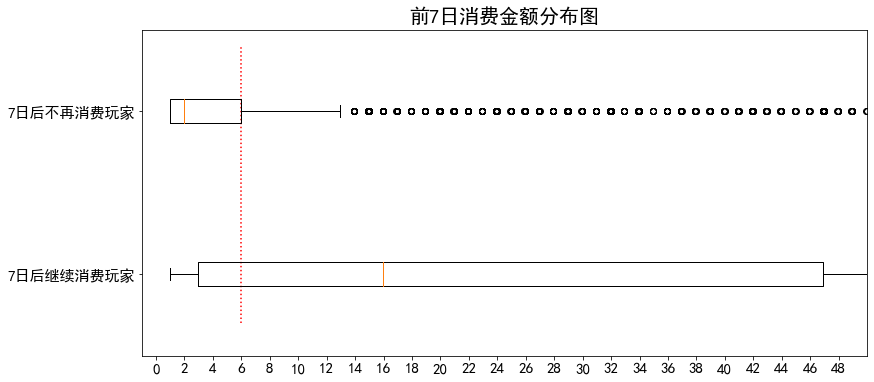

In [27]:
plt.figure(figsize=(13,6))
plt.boxplot([Seven_day_payAmount[Seven_day_payAmount != y][Seven_day_payAmount != 0],Seven_day_payAmount[Seven_day_payAmount == y][Seven_day_payAmount != 0]],labels=["7日后继续消费玩家","7日后不再消费玩家"],vert=False,showmeans=False)
plt.xlim(-1,50)
plt.title('前7日消费金额分布图',fontsize=20.0)
plt.xticks(range(0,50,2),fontsize=15.0)
plt.yticks(fontsize=15.0)
plt.vlines(6.0,ymin = plt.ylim()[0]+0.2,ymax = plt.ylim()[1]-0.1,colors="red",linestyles="dotted")
plt.show()

- 但继续付费玩家的分布要靠右许多，说明7日后付费玩家在前7日消费更多。
> - <font color="red"> **高价值玩家评判的第一个可能的标准：前7日消费超过6元的玩家是更有价值的玩家**</font><br><br>
以此推测，新手礼包设置为6元左右，或许可以明确辨析出游戏玩家用户对于游戏过程中可接受付费范围。

考虑到后续付费用户有50%都付了16元及以上，可以推测这个金额点应该是在16元以下的，因此设置潜在阈值金额的范围为1-16。
用于判别玩家用户高低价值的阈值！

In [28]:
PotentialPoints = range(1,16)
[*PotentialPoints]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

遍历寻找最佳阈值点，保证在此阈值金额下，玩家继续消费的可能性更高！——联合可视化模块
1
阈值1时的继续消费玩家比例：37.627%
阈值1时的不再消费玩家比例：62.373%
前500高消费用户金额占比：-0.247%
2
阈值2时的继续消费玩家比例：43.717%
阈值2时的不再消费玩家比例：56.283%
前500高消费用户金额占比：-0.126%
3
阈值3时的继续消费玩家比例：45.676%
阈值3时的不再消费玩家比例：54.324%
前500高消费用户金额占比：-0.086%
4
阈值4时的继续消费玩家比例：46.515%
阈值4时的不再消费玩家比例：53.485%
前500高消费用户金额占比：-0.070%
5
阈值5时的继续消费玩家比例：48.032%
阈值5时的不再消费玩家比例：51.968%
前500高消费用户金额占比：-0.039%
6
阈值6时的继续消费玩家比例：50.534%
阈值6时的不再消费玩家比例：49.466%
前500高消费用户金额占比：0.011%
当7日内消费金额大于6.00时，玩家继续消费的可能性比不再氪金的可能性更高！


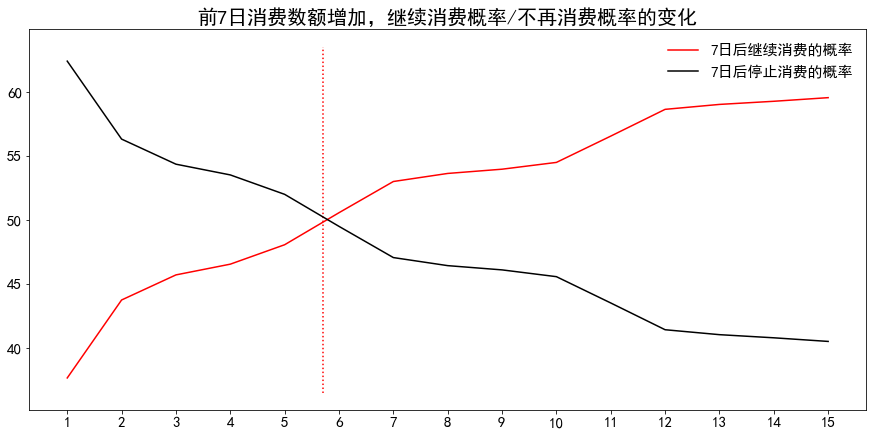

In [29]:
print('''遍历寻找最佳阈值点，保证在此阈值金额下，玩家继续消费的可能性更高！——联合可视化模块''')
for i in PotentialPoints:
    Higher_Than_Point = Seven_day_payAmount[Seven_day_payAmount>=i] #取出所有7天内付费金额超出阈值金额i的付费用户
    Keep_Paid = len(Higher_Than_Point[Seven_day_payAmount != y])/len(Higher_Than_Point) #这些用户中，继续付费的用户所占的比例
    Stop_Paid = len(Higher_Than_Point[Seven_day_payAmount == y])/len(Higher_Than_Point) #等于上面的1 - Keep_Paid
    print(i)
    print("阈值" + str(i)+ "时的继续消费玩家比例：{:.3f}%".format(100*Keep_Paid))
    print("阈值" + str(i)+ "时的不再消费玩家比例：{:.3f}%".format(100*Stop_Paid))
    print("前500高消费用户金额占比：{:.3f}%".format(Keep_Paid - Stop_Paid))
    if Keep_Paid - Stop_Paid > 0:
        print("当7日内消费金额大于{:.2f}时，玩家继续消费的可能性比不再氪金的可能性更高！".format(i))
        break
##################################
KeepPaidList = []
StopPaidList = []
for i in PotentialPoints:
    Higher_Than_Point = Seven_day_payAmount[Seven_day_payAmount>=i] #取出所有7天内付费金额超出阈值金额i的付费用户
    Keep_Paid = len(Higher_Than_Point[Seven_day_payAmount != y])/len(Higher_Than_Point) #这些用户中，继续付费的用户所占的比例
    Stop_Paid = len(Higher_Than_Point[Seven_day_payAmount == y])/len(Higher_Than_Point) #等于上面的1 - Keep_Paid
    KeepPaidList.append(100*Keep_Paid)
    StopPaidList.append(100*Stop_Paid)
plt.figure(figsize=(15,7))
plt.plot(PotentialPoints,KeepPaidList,label="7日后继续消费的概率",color="red")
plt.plot(PotentialPoints,StopPaidList,label="7日后停止消费的概率",color="k")
#plt.xlim(-1,50)
plt.title('前7日消费数额增加，继续消费概率/不再消费概率的变化',fontsize=20.0)
plt.yticks(fontsize=15.0)
plt.xticks(range(0,16,1),fontsize=15.0)
plt.legend(fontsize = 15.0, frameon = False)
plt.vlines(5.7,ymin = plt.ylim()[0]+0.1,ymax = plt.ylim()[1]-0.1,colors="red",linestyles="dotted")
plt.show()

- 在前7日内付费6元以下的玩家，无论是否自然流失，未来消费的可能性都是小于不再付费的可能性的。
- 可以通过设置游戏体验，给与付费5元左右的用户更多的“刺激”，让他们后续继续付费。也可选择直接放弃6元以下的付费玩家，体验维持现状或减少资源分配，让更多的资源/服务围绕更有可能付费的玩家展开。

### S4.回看一下收入经营层面！

In [30]:
print("7天！!!")
RevenueFocus(y)
print("45天！!!")
RevenueFocus(Seven_day_payAmount)

7天！!!
付费率：2.022%
付费人数：21203
转化总金额：1944914.070
ARPU：1.855
ARPPU：91.728
前500高消费玩家金额占比：66.897%
前1000高消费玩家金额占比：78.783%
前5000高消费玩家金额占比：96.100%
45天！!!
付费率：1.824%
付费人数：19126
转化总金额：574387.680
ARPU：0.548
ARPPU：30.032
前500高消费玩家金额占比：58.899%
前1000高消费玩家金额占比：70.765%
前5000高消费玩家金额占比：93.063%


In [31]:
y.max()

32977.81

- 来看ARPU与ARPPU数据。
> 1. ARPU是全服用户平均收入，ARPPU是全服付费玩家平均收入，目前来看全服的ARPU较低，但ARPPU还不错，这说明虽然付费人数不多，但是大款的付费能力相对较强。
> 2. 从前5000高消费玩家金额占比来看，45日时全服高消费金额前5000的人(这一部分玩家占比小于0.4%)提供了全服93%的收入，大款们贡献巨大。
这可能表示，《野蛮时代》中的消费行为应该与玩家竞争力有较为直接的联系，因为许多大款玩家非常偏爱强PK类游戏，付费可以直接让PVP变得异常简单，不过全服最氪金玩家在一个月内的消费有33000元，在SLG手游领域并非一个很高的数字，
如果游戏体验优秀，应该还有很大的上升空间。而付费人数不多的问题还可以改善，游戏整体的经营成果还可以上一个台阶。

### P3.游戏内特征的探索分析

    ### S1.通过在线时长，判别一下玩家是否以超出常规的速度流失；

- 通常来说，任意手游的次日留存率及格线应该在50%以上，7日留存应该在30%左右，一个成功的手游则需要在7日达到50%左右的留存；——行业者经验论；
- 而目前通过前面的种种迹象，《野蛮时代》可能并未达到这个次日留存50%的及格线。
- 在特征当中，有一列“在线时长”，是前7日用户在线的时长。通过判断用户在线时长，可以大约估计出用户流失的速度。

In [32]:
print("取出在线时长，看一下最长时间是多少！")
user_online_time = data.loc[:,"在线时长"]
user_online_time.max()

取出在线时长，看一下最长时间是多少！


2049.666667

- 前7日内游戏时长最长的玩家玩了2049分钟，即24个小时，每日玩5个小时左右！！也是蛮拼命地！


In [33]:
print("在线分钟时长的描述性统计结果！")
user_online_time.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]) #查看一下90%以上的分布

在线分钟时长的描述性统计结果！


count   1048575.000
mean         10.245
std          39.098
min           0.000
25%           0.500
50%           1.833
75%           5.000
90%          14.833
95%          41.500
99%         183.710
max        2049.667
Name: 在线时长, dtype: float64

- 75%的玩家在前7日一共只玩了5分钟还不到。。。这是说超过75%的玩家只是稍微看了一眼游戏就被劝退了；过场动画，介绍基本就这么点儿时间。。。
- SLG游戏天生会充满许多任务、奖励和剧情，除非玩家登录即退出，否则登入一次至少应该停留5-10分钟；新玩家停留的时间应当更长（有非常多的比如新手教程，了解探索、任务说明等）。
- 如果一个玩家在注册游戏后第二天依然被留存下来、并参与到游戏当中，那两天在线时长至少也应该有10-15分钟。
- 但目前75%的玩家在前7日内只玩了5分钟，太少了，基本是7天内就看了一眼新手教程可能就卸载了。。。
- 90%的玩家在7日内只玩了15分钟以下，平均一天2分钟多一点，大概就是做个每日任务，领一下签到奖励等等，积极性也并不是很高。。。
- 玩家的确以比较快的趋势流失，付费率不高在情理之中。

In [34]:
print("那个在线时长最长的玩家有无可能是管理员测试账号之类的？？？")
(data["在线时长"] > 1600).sum() #可能测试人员，GM

那个在线时长最长的玩家有无可能是管理员测试账号之类的？？？


1

In [35]:
print("这个玩家还好不是所谓的管理员。。。从资源获取数量，PVP次数来看是正常玩家，也有付费！这个玩家用户够努力！！！")
data.loc[data["在线时长"] > 1600,:] 

这个玩家还好不是所谓的管理员。。。从资源获取数量，PVP次数来看是正常玩家，也有付费！这个玩家用户够努力！！！


字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
488497,645487,2018/3/4 13:43,697852,300255,0,0,6000,0,690379,196602,...,5,0,0,2,2,2,2049.667,0.000,0,0.000


    ### S2.尝试查找有过消费行为的玩家们前7日的在线时长！

In [36]:
print("有过消费行为的只有25%以下的玩家在线时间在半小时左右，游戏时间明显比那些未消费的玩家长很多！")
Paiduser_online_time = data.loc[data["付费金额"] != 0,"在线时长"]
Paiduser_online_time.describe([0.25,0.5,0.75,0.9,0.99]).T

有过消费行为的只有25%以下的玩家在线时间在半小时左右，游戏时间明显比那些未消费的玩家长很多！


count   19126.000
mean      141.138
std       149.949
min         0.333
25%        33.000
50%        90.000
75%       196.333
90%       347.250
99%       674.542
max      1394.667
Name: 在线时长, dtype: float64

In [37]:
print('''存不存在有钱骚的玩家呢？！！！！！！——波尔坤卡！！！！！！真有！！
30个花1块！还有俩花100！有钱任性！！！！！！
''')
data.loc[data["在线时长"]<=1,"付费金额"].value_counts()

存不存在有钱骚的玩家呢？！！！！！！——波尔坤卡！！！！！！真有！！
30个花1块！还有俩花100！有钱任性！！！！！！



0.000     407802
0.990         30
4.990          2
99.990         2
56.950         1
25.970         1
36.960         1
1.990          1
5.980          1
Name: 付费金额, dtype: int64

- 在线时间很长的玩家也不一定就是高消费大佬肝帝玩家
- 在线时间很短的玩家也不一定就完全不消费的低价值玩家
- 如何就在线时间这个点来进行玩家用户价值判断呢？

In [38]:
print('''看一下在线时长很少的玩家们，贡献的消费金额以及比例；''')
for playtime in [1,5,15,20,25,30]:    
    MeanPay45 = data.loc[data["在线时长"]<playtime,"45日付费金额"].mean()
    TotalPay45 = data.loc[data["在线时长"]<playtime,"45日付费金额"].sum()
    MeanPay7 = data.loc[data["在线时长"]<playtime,"付费金额"].mean()
    TotalPay7 = data.loc[data["在线时长"]<playtime,"付费金额"].sum()   
    print("一周在线时长不足{}分钟".format(playtime))
    print("\t45日平均消费额为{:.3f}元，45日总消费额为{:.3f}元".format(MeanPay45,TotalPay45))
    print("\t7日平均消费额为{:.3f}元，7日总消费额为{:.3f}元".format(MeanPay7,TotalPay7))
    print("\t7日消费金额占比{:.3f}%，45日消费金额占比{:.3f}%".format(100*TotalPay7/(data["付费金额"].sum()),100*TotalPay45/(data["45日付费金额"].sum())))



看一下在线时长很少的玩家们，贡献的消费金额以及比例；
一周在线时长不足1分钟
	45日平均消费额为0.034元，45日总消费额为12752.090元
	7日平均消费额为0.001元，7日总消费额为353.610元
	7日消费金额占比0.062%，45日消费金额占比0.656%
一周在线时长不足5分钟
	45日平均消费额为0.023元，45日总消费额为17971.620元
	7日平均消费额为0.002元，7日总消费额为1933.550元
	7日消费金额占比0.337%，45日消费金额占比0.924%
一周在线时长不足15分钟
	45日平均消费额为0.033元，45日总消费额为30709.700元
	7日平均消费额为0.009元，7日总消费额为8217.970元
	7日消费金额占比1.431%，45日消费金额占比1.579%
一周在线时长不足20分钟
	45日平均消费额为0.039元，45日总消费额为37681.470元
	7日平均消费额为0.012元，7日总消费额为11872.410元
	7日消费金额占比2.067%，45日消费金额占比1.937%
一周在线时长不足25分钟
	45日平均消费额为0.046元，45日总消费额为44900.630元
	7日平均消费额为0.017元，7日总消费额为16177.540元
	7日消费金额占比2.816%，45日消费金额占比2.309%
一周在线时长不足30分钟
	45日平均消费额为0.051元，45日总消费额为50520.590元
	7日平均消费额为0.019元，7日总消费额为19039.270元
	7日消费金额占比3.315%，45日消费金额占比2.598%


> 1. 不难发现，在线时长很少的玩家们贡献的氪金数额很少，30分钟的玩家用户，消费金额也才3%不到！
> 2. 所以之后进行建模时，可以忽略一部分在线时间很短的玩家用户。
> 3. 在这里，可以将一周在线时长不足15或20分钟的用户判断为低价值用户。

In [39]:
print('''最肝的前0.5%的玩家的7日在线时长''')
data["在线时长"].sort_values(ascending=False)[:round(data.shape[0]*0.005)] 

最肝的前0.5%的玩家的7日在线时长


488497   2049.667
882241   1482.000
62992    1394.667
992862   1388.333
213886   1341.833
           ...   
844900    271.500
607524    271.500
27638     271.500
264141    271.500
151731    271.500
Name: 在线时长, Length: 5243, dtype: float64

In [40]:
print('''最肝的前0.5%的玩家消费金额：''')
for playtime in [500,600,700,800,900,1000,1200]:    
    MeanPay45 = data.loc[data["在线时长"]>=playtime,"45日付费金额"].mean()
    TotalPay45 = data.loc[data["在线时长"]>=playtime,"45日付费金额"].sum()
    MeanPay7 = data.loc[data["在线时长"]>=playtime,"付费金额"].mean()
    TotalPay7 = data.loc[data["在线时长"]>=playtime,"付费金额"].sum()    
    print("一周在线时长超过{}分钟".format(playtime))
    print("\t45日平均消费金额为{:.3f}元，45日总消费额为{:.3f}元".format(MeanPay45,TotalPay45))
    print("\t7日平均消费金额为{:.3f}元，7日总消费额为{:.3f}元".format(MeanPay7,TotalPay7))
    print("\t7日消费金额占比{:.3f}%，45日消费金额占比{:.3f}%".format(100*TotalPay7/(data["付费金额"].sum()),100*TotalPay45/(data["45日付费金额"].sum())))

最肝的前0.5%的玩家消费金额：
一周在线时长超过500分钟
	45日平均消费金额为400.859元，45日总消费额为439341.800元
	7日平均消费金额为104.437元，7日总消费额为114462.610元
	7日消费金额占比19.928%，45日消费金额占比22.589%
一周在线时长超过600分钟
	45日平均消费金额为496.482元，45日总消费额为271079.310元
	7日平均消费金额为135.515元，7日总消费额为73991.110元
	7日消费金额占比12.882%，45日消费金额占比13.938%
一周在线时长超过700分钟
	45日平均消费金额为500.085元，45日总消费额为144524.550元
	7日平均消费金额为126.610元，7日总消费额为36590.150元
	7日消费金额占比6.370%，45日消费金额占比7.431%
一周在线时长超过800分钟
	45日平均消费金额为356.364元，45日总消费额为50247.270元
	7日平均消费金额为82.885元，7日总消费额为11686.720元
	7日消费金额占比2.035%，45日消费金额占比2.584%
一周在线时长超过900分钟
	45日平均消费金额为248.531元，45日总消费额为19633.920元
	7日平均消费金额为29.391元，7日总消费额为2321.890元
	7日消费金额占比0.404%，45日消费金额占比1.010%
一周在线时长超过1000分钟
	45日平均消费金额为89.975元，45日总消费额为3329.090元
	7日平均消费金额为20.118元，7日总消费额为744.350元
	7日消费金额占比0.130%，45日消费金额占比0.171%
一周在线时长超过1200分钟
	45日平均消费金额为5.084元，45日总消费额为50.840元
	7日平均消费金额为4.585元，7日总消费额为45.850元
	7日消费金额占比0.008%，45日消费金额占比0.003%


- 在线时长在800分钟时，出现了，45日消费金额占比的下降！所以可以有以下结论：
> 1. 许多玩家虽然深度参与游戏，但是“好肝不好氪”，所以过于肝的用户也不是高价值玩家用户。
> 2. 可以规定，一周在线时长超出800分钟的用户为（消费层面）低价值用户。
> 3. 同样的，消费金额用户一般在资源上占绝对的主导，但是资源很多的用户不一定是高消费用户。

In [41]:
data.loc[data["付费金额"] != 0,"木头获取数量"].describe() #资源量上消费玩家站占据大多数江山！
# data.loc[data["付费金额"] == 0,"木头获取数量"].describe() #未消费玩家的量级明显要低很多！

count        19126.000
mean      10645082.747
std       35500161.935
min              0.000
25%        1939751.250
50%        5012212.500
75%       10030185.250
max     1203395293.000
Name: 木头获取数量, dtype: float64

In [42]:
data.loc[data["付费金额"] == 0,"木头获取数量"].describe()

count     1029449.000
mean       256854.741
std        861896.167
min             0.000
25%             0.000
50%         38538.000
75%        142013.000
max     100740415.000
Name: 木头获取数量, dtype: float64

In [43]:
print("未消费的，并且垄断木头资源的某个玩家！！！——可能两种倾向；一是资源专精技术型玩家，二是异常刷资源型玩家！")
data[data["木头获取数量"] == data.loc[data["付费金额"] == 0,"木头获取数量"].max()] 


未消费的，并且垄断木头资源的某个玩家！！！——可能两种倾向；一是资源专精技术型玩家，二是异常刷资源型玩家！


字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
265134,301615,2018/2/24 6:16,100740415,99888330,57366294,56791340,40000,0,71963120,71346424,...,173,1,1,1,0,0,25.667,0.000,0,0.000


- 因此可能在一定程度上认为：拥有众多资源、但在7日内却没有消费过的玩家，是（是否消费层面上）的低价值用户玩家。

    ### S3.一些资源特征的分布与偏度：是否对新手玩家友好？新手玩家资源获取难度设置合理吗？

In [44]:
print("再重新看一下所有数据的描述性结果！！！！！！")
all_data_info = data.describe([0.25, 0.5, 0.75, 0.9, 0.99]).T
all_data_info = all_data_info.reset_index()
all_data_info

再重新看一下所有数据的描述性结果！！！！！！


,字段解释,count,mean,std,min,25%,50%,75%,90%,99%,max
0,玩家唯一ID,1048575.000,661162.054,380865.884,1.000,298624.500,682935.000,1005461.500,1169794.600,1285334.260,1313932.000
1,木头获取数量,1048575.000,446335.941,5064362.536,0.000,0.000,39129.000,149892.500,606875.200,7298399.560,1203395293.000
2,木头消耗数量,1048575.000,363509.370,3824456.251,0.000,0.000,8830.000,96996.000,416687.200,6684409.900,799587506.000
3,石头获取数量,1048575.000,189901.660,4840094.044,0.000,0.000,0.000,0.000,20000.000,3259000.260,1185764691.000
4,石头消耗数量,1048575.000,138534.841,3526253.804,0.000,0.000,0.000,0.000,0.000,2686411.640,796237770.000
...,...,...,...,...,...,...,...,...,...,...,...
103,PVE胜利次数,1048575.000,2.482,11.687,0.000,0.000,0.000,1.000,3.000,62.000,373.000
104,在线时长,1048575.000,10.245,39.098,0.000,0.500,1.833,5.000,14.833,183.710,2049.667
105,付费金额,1048575.000,0.548,23.517,0.000,0.000,0.000,0.000,0.000,1.980,7457.950
106,付费次数,1048575.000,0.058,0.720,0.000,0.000,0.000,0.000,0.000,2.000,105.000


In [45]:
all_data_info.columns,all_data_info["字段解释"].head()

(Index(['字段解释', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', '90%',
        '99%', 'max'],
       dtype='object'),
 0    玩家唯一ID
 1    木头获取数量
 2    木头消耗数量
 3    石头获取数量
 4    石头消耗数量
 Name: 字段解释, dtype: object)

In [46]:
all_feature_skewness = pd.DataFrame()
for feature in all_data_info["字段解释"]:
    if feature == "玩家唯一ID":
        continue
    else :
        all_feature_skewness.loc[feature, "该特征中位数"] = float(all_data_info.loc[all_data_info["字段解释"] == feature]["50%"])
        all_feature_skewness.loc[feature, "该特征均值"]   = float(all_data_info.loc[all_data_info["字段解释"] == feature]["mean"])
def function(df):
    if   df['该特征中位数'] > df['该特征均值']:
        return '左偏分布'
    elif df['该特征中位数'] < df['该特征均值']:
        return '右偏分布'
    else :
        return '对称分布'
all_feature_skewness["偏态情况"] = all_feature_skewness.apply(function, axis=1)
all_feature_skewness

,该特征中位数,该特征均值,偏态情况
木头获取数量,39129.000,446335.941,右偏分布
木头消耗数量,8830.000,363509.370,右偏分布
石头获取数量,0.000,189901.660,右偏分布
石头消耗数量,0.000,138534.841,右偏分布
象牙获取数量,0.000,80551.224,右偏分布
...,...,...,...
PVE胜利次数,0.000,2.482,右偏分布
在线时长,1.833,10.245,右偏分布
付费金额,0.000,0.548,右偏分布
付费次数,0.000,0.058,右偏分布


- **数据基本呈现右偏，说明游戏中拥有大量资源人较少，因为相比起中位数，大部分玩家来说在资源/等级上都值离0更近**。
- 现在已经知道玩家在前7天是严重流失的，资源分布会右偏也合理，但为何玩家会流失如此严重呢？可能从流量端开始就有问题（比如投放到了不太合适的流量渠道）、投放的广告可能有问题（比如让玩家误以为是其他类型游戏），也可能是游戏美工不足、吸引力较低等方面（在75%的玩家看一眼就被劝退的前提下，有理由相信游戏美工和流畅度有较大问题）。
- 除了上述理由，玩家用户大量流失还可能是游戏对新手不太友好或者游戏平衡性严重受氪金影响导致的。如果游戏中资源获取很困难，比如大部分资源都需要较长的时间或高额消费来进行积累（这可能是刺激消费的策略：新手阶段不友好，游戏上手难度大），大部分玩家在10~15分钟内无法获得足够的刺激与获得感，那在半小时内流失的可能性就很高。
- 可以通过尝试着观察几个资源层次的平均游戏时间，以此来判断游戏中的资源是否难以获得：

    ### S3.具体某个特征为例看一下获取难度

In [47]:
data["木头获取数量"].describe()

count      1048575.000
mean        446335.941
std        5064362.536
min              0.000
25%              0.000
50%          39129.000
75%         149892.500
max     1203395293.000
Name: 木头获取数量, dtype: float64

In [48]:
print("在线时长约5个小时，即每天玩1个小时不到，一周即可获得木头资源过亿！")
data.loc[data["木头获取数量"] >= 1203395293,"在线时长"] 

在线时长约5个小时，即每天玩1个小时不到，一周即可获得木头资源过亿！


428443   307.000
Name: 在线时长, dtype: float64

In [49]:
print("平均在线约4分钟即可获得15w木头")
data.loc[data["木头获取数量"] == 149892,"在线时长"].mean()

平均在线约4分钟即可获得15w木头


4.0

In [50]:
print("平均在线0.79分钟即可获得3.9w木头")
data.loc[data["木头获取数量"] == 39129,"在线时长"].mean() 

平均在线0.79分钟即可获得3.9w木头


0.7916665

- 从结果来看，至少木头资源一点也不难获得，反而来得太容易了。
- 在现有数据下，可以通过分析资源存量来分析游戏中资源获取难度分类的合理性。

    ### S4.所有特征的偏度峰度分析！

In [51]:
print("取出所有和资源相关的特征！并计算偏度峰度！")
resource = data.iloc[:,2:-10]
sak = pd.DataFrame()
for idx,ColName in enumerate(resource.columns):
    sak.loc[idx,"特征"] = ColName
    column = data.loc[:,ColName]
    sak.loc[idx,"偏度"] = column.skew() #偏度
    sak.loc[idx,"峰度"] = column.kurt() #峰度
    sak.loc[idx,"均值"] = column.mean() #均值
sak.head()

取出所有和资源相关的特征！并计算偏度峰度！


,特征,偏度,峰度,均值
0,木头获取数量,98.120,14286.104,446335.941
1,木头消耗数量,89.489,12238.901,363509.370
2,石头获取数量,112.644,17743.225,189901.660
3,石头消耗数量,110.304,17092.687,138534.841
4,象牙获取数量,109.728,16293.306,80551.224


In [52]:
print("按照偏度降序排列！")
sak.sort_values("偏度").head(20)

按照偏度降序排列！


,特征,偏度,峰度,均值
96,科研：资源帮助容量,0.000,0.000,0.000
94,科研：增援部队容量,0.000,0.000,0.000
95,科研：行军大小,0.000,0.000,0.000
34,建筑：要塞等级,1.247,0.986,2.059
35,建筑：据点传送门等级,1.402,1.503,1.735
32,建筑：士兵小屋等级,1.904,3.433,1.277
42,建筑：魔法幸运树等级,2.057,3.400,1.134
36,建筑：兵营等级,2.156,4.531,1.244
33,建筑：治疗小井等级,2.215,4.696,1.003
41,建筑：瞭望塔等级,2.471,5.958,0.882


感觉偏度峰度之间相关性强！


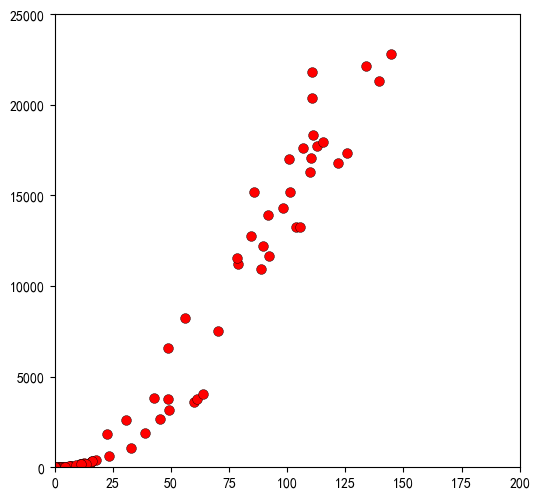

,偏度,峰度,均值
偏度,1.000,0.967,-0.012
峰度,0.967,1.000,-0.057
均值,-0.012,-0.057,1.000


In [53]:
print("感觉偏度峰度之间相关性强！")
plt.figure(figsize=(6,6),dpi=100)
plt.scatter("偏度","峰度", data = sak,s = 50,c = "red",edgecolors = "k",linewidth = 0.3);
plt.xlim(0, 200) #控制横纵坐标的范围
plt.ylim(0, 25000)
plt.show()
sak.corr()

- 鉴于二者呈现强的正相关0.967, 因此可以只考虑偏度与均值，不再考虑峰度的情况了。
- **可以绘制横坐标为偏度，纵坐标为均值的散点图，概括出偏度与均值之间的关系，并总结出不同资源/不同等级的设置类型，以此来判断游戏中的各项资源的获得难易程度是否合理**。
- 在绘图之前，大致可以判断，均值与偏度应该可以以如下方式分割特征的类型：

- 为了简要说明，用DNF中的材料道具来类比！
> - A类 **均值高，偏度低**：玩家拥有该资源的分布较为均匀，并且大家都拥有很多这个资源，这类资源是最容易获取的；——**炉岩碳，无色**
> - B类 **均值高，偏度也高**：玩家拥有该资源的分布不均匀，少量玩家掌握巨量资源（长尾会非常非常长），拉高了均值，
这类资源可能是需要玩家花费金钱的资源，也可能是爆肝才能获得的资源；——**活动爆肝赠送的高级时装兑换券！**
> - C类 **均值低，偏度也低**：玩家拥有该资源的分布较为均匀，但大家都没有这个资源，这类资源可能是需要时间来积累才能够获得的，随着开服时间变长，这类资源应该会逐渐变成其他类型的资源；——**混沌魔石碎片，英雄的宿命，无限的永恒！**
> - D类 **均值低，偏度高**：玩家拥有该资源的分布不均匀，只有少量玩家掌握该资源，但是掌握的总量也不多。这类资源天生稀缺并且无法靠高消费获得（比如必须触发特定剧情/达到特定成就才能够获得的资源），只有少数人能够拥有；——**稀有史诗，明光追影刀，光焰烈日裁决、白鸟人皮肤外观（不是光明套）**

- 在一个健康的游戏中，A类资源应该是最多的，这类资源决定了剧本能够被推进的程度、决定了大部分玩家的游戏体验，B类资源主要用于付费，收入的主要来源，但可能严重破坏游戏平衡，D类资源主要在于增加游戏的趣味和公平性，应该是最少的。一个游戏的A类资源要足够多，才算是对新手比较友好，只要绘制出散点图，四类资源的分布情况就目了然了。

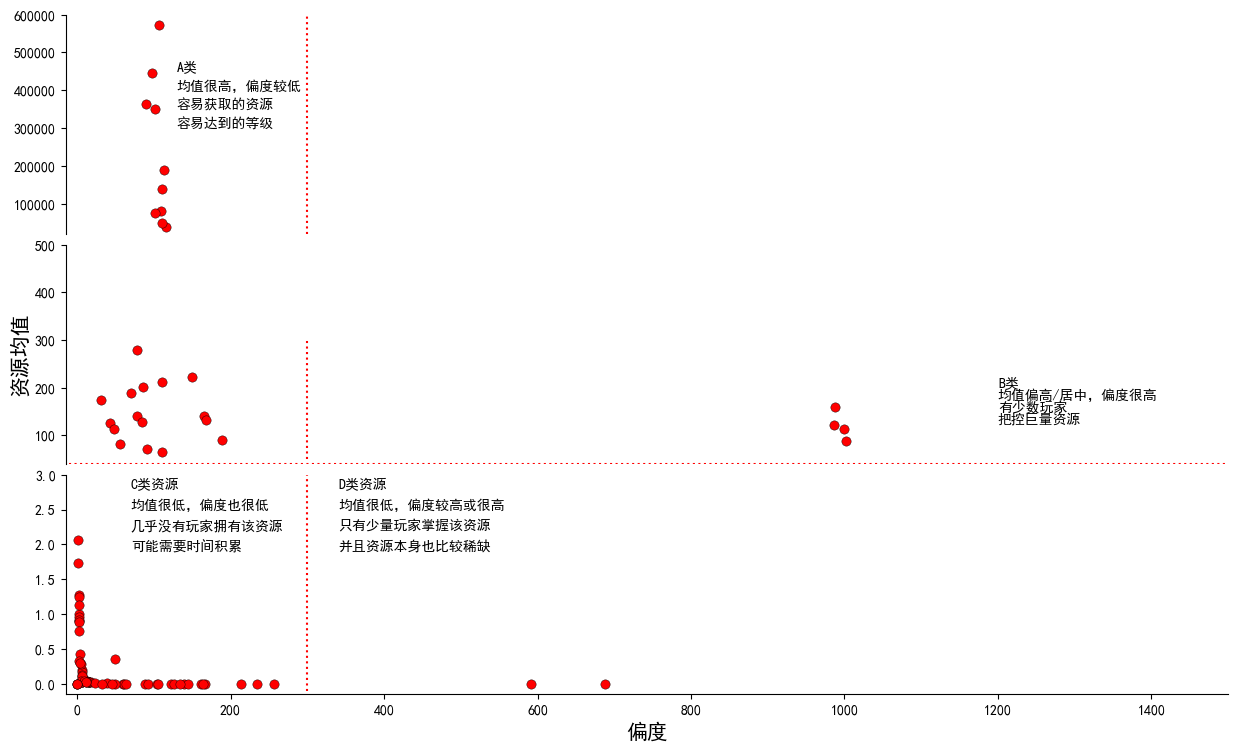

In [54]:
plt.figure(figsize=(15,9),dpi=100)
#绘制三个坐标轴不一样的图像上，首先是A类
plt.subplot(311)
plt.scatter("偏度","均值", data = sak,s = 45,c = "red",edgecolors = "k",linewidth = 0.3);
plt.xlim(-15, 1500) #控制横纵坐标的范围
plt.ylim(20000, 600000)
plt.vlines(300, 20000, 600000,colors="red",linestyles="dotted")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.yticks(fontsize=10)
plt.text(130,450000,s="A类")
plt.text(130,400000,s="均值很高，偏度较低")
plt.text(130,350000,s="容易获取的资源")
plt.text(130,300000,s="容易达到的等级")
plt.xticks([])

#B类
plt.subplot(312)
plt.scatter("偏度","均值", data = sak,s = 45,c = "red",edgecolors = "k",linewidth = 0.3);
plt.xlim(-15, 1500)
plt.ylim(40, 500)
plt.vlines(300, 50, 300,colors="red",linestyles="dotted")
plt.hlines(40,-10, 1500,colors="red",linestyles="dotted")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.yticks(fontsize=10)
plt.ylabel("资源均值", fontsize=15)
plt.text(1200,200,s="B类")
plt.text(1200,175,s="均值偏高/居中，偏度很高")
plt.text(1200,150,s="有少数玩家")
plt.text(1200,125,s="把控巨量资源")
plt.xticks([])

#C类
plt.subplot(313)
plt.scatter("偏度","均值", data = sak,s = 45,c = "red",edgecolors = "k",linewidth = 0.3);
plt.xlim(-15, 1500)
plt.ylim(-0.15, 3)
plt.vlines(300, -0.1, 5,colors="red",linestyles="dotted")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("偏度", fontsize=15)
plt.yticks(fontsize=10)
plt.text(70,2.8,s="C类资源")
plt.text(70,2.5,s="均值很低，偏度也很低")
plt.text(70,2.2,s="几乎没有玩家拥有该资源")
plt.text(70,1.9,s="可能需要时间积累")
plt.text(340,2.8,s="D类资源")
plt.text(340,2.5,s="均值很低，偏度较高或很高")
plt.text(340,2.2,s="只有少量玩家掌握该资源")
plt.text(340,1.9,s="并且资源本身也比较稀缺")
plt.subplots_adjust(hspace=0.05)
plt.show()

- OS：(不同特征之间量纲差的的有点儿多，还是拿出来单独看吧。。。)

In [55]:
#A类
A = sak.loc[sak["均值"] > 3,:].loc[sak["偏度"]<300,:]
#B类
B = sak.loc[sak["均值"] > 3,:].loc[sak["偏度"]>300,:]
#C类
C = sak.loc[sak["均值"] < 3,:].loc[sak["偏度"]<300,:].shape[0]
#D类
D = sak.loc[sak["均值"] < 3,:].loc[sak["偏度"]>300,:].shape[0]

- 是否影响新玩家用户就要看A类！

In [56]:
data.loc[:,A["特征"]].describe().T

,count,mean,std,min,25%,50%,75%,max
字段解释,,,,,,,,
木头获取数量,1048575.000,446335.941,5064362.536,0.000,0.000,39129.000,149892.500,1203395293.000
木头消耗数量,1048575.000,363509.370,3824456.251,0.000,0.000,8830.000,96996.000,799587506.000
石头获取数量,1048575.000,189901.660,4840094.044,0.000,0.000,0.000,0.000,1185764691.000
石头消耗数量,1048575.000,138534.841,3526253.804,0.000,0.000,0.000,0.000,796237770.000
象牙获取数量,1048575.000,80551.224,2265183.976,0.000,0.000,0.000,0.000,497686593.000
象牙消耗数量,1048575.000,36896.504,1815712.635,0.000,0.000,0.000,0.000,448197157.000
肉获取数量,1048575.000,572687.784,5982317.952,0.000,0.000,32625.000,131450.500,1470643810.000
肉消耗数量,1048575.000,348908.328,3560458.364,0.000,0.000,6220.000,66054.000,888953714.000
魔法获取数量,1048575.000,75965.932,1039345.797,0.000,0.000,0.000,0.000,240559018.000


- 从分析的结果来看，各项资源的配比数量其实还算合理。
- 假设一款游戏只想服务消费型玩家，那B类资源会很多、大量A类资源的获取渠道也会转向氪金方向，但《野蛮时代》明显没有这样的设计，在游戏早期只有兵种萨满相关的集中资源和技能是需要消费的，说明游戏依然在致力于为普通玩家提供较好的体验，所以大部分玩家应该不是因为新手关太难、剧情无法推进才退游的。然而，各类资源的可获取量其实有很大的差异，基础资源动辄就上百万甚至上亿，可能会让玩家获得感严重不足。
- 而从A类资源的分布来看，只有木头和肉这两种最最最基础的资源是分布较为正常的，其他资源都是严重右偏，**说明“留存率低”是原因，“资源数据的异常”是结果；同时数值策划应该细心规划一下数字上给玩家用户带来的体验感**。除此之外，还有可能的情况就是产品逻辑不顺、获得感不足、美工不足、系统BUG（比如疯狂闪退等等）、或者强烈的捞金感/不高级感让大部分用户在第一天就流失掉了。

    ### S4.玩家用户间的平衡性影响：消费与战斗优势

In [57]:
Seven_day_consume_user = data[data["付费金额"] !=0]
Seven_day_unconsume_user = data[data["付费金额"] ==0]
print("7日有过消费的玩家的人均PVP次数——有过消费的玩家是否热衷于PVP比赛！！！")
Seven_day_consume_user["PVP次数"].mean()

7日有过消费的玩家的人均PVP次数——有过消费的玩家是否热衷于PVP比赛！！！


25.13771828923978

In [58]:
print("7日有过消费的玩家，PVP胜率分布！")
(Seven_day_consume_user["PVP胜利次数"]/Seven_day_consume_user["PVP次数"]).describe()

7日有过消费的玩家，PVP胜率分布！


count   16306.000
mean        0.534
std         0.361
min         0.000
25%         0.200
50%         0.600
75%         0.871
max         1.000
dtype: float64

- 可以看到，人均PVP胜率是53.4%，对付费玩家来说是个可以接受的数字，但并不是特别大的优势。其中count数是少于总付费玩家的人数的，说明有部分玩家的PVP次数为0，为避免除0错误因此剔除了这些玩家。不参与PVP的玩家占比为：

In [59]:
print("当然也有消费的玩家，不玩PVP，有15%")
1 - (16306/Seven_day_consume_user.shape[0])

当然也有消费的玩家，不玩PVP，有15%


0.14744327094008158

In [60]:
print("7日未消费的玩家人均PVP次数")
Seven_day_unconsume_user["PVP次数"].mean()

7日未消费的玩家人均PVP次数


1.691989598319101

In [61]:
print("7日未消费的玩家PVP胜率分布")
(Seven_day_unconsume_user["PVP胜利次数"]/Seven_day_unconsume_user["PVP次数"]).describe()

7日未消费的玩家PVP胜率分布


count   243271.000
mean         0.249
std          0.354
min          0.000
25%          0.000
50%          0.000
75%          0.500
max          1.000
dtype: float64

- 对未消费的玩家而言，人均PVP胜率只有25%，并且75%的人的场均胜率只有50%；这个条件对未消费的玩家来说的确比较苛刻。
- 同样，不消费的玩家中也有部分玩家的PVP次数为0，即一次也没有参与。

In [62]:
print("来看未消费的玩家中参与PVP的人数占比：")
1 - (243271/Seven_day_unconsume_user.shape[0])

来看未消费的玩家中参与PVP的人数占比：


0.7636881477372847

- 这个比例太高了，不曾消费的玩家用户中有许多人可能是已经流失的玩家用户，因此当然不会参与PVP对战。

In [63]:
print("是否消费会影响玩家间的对战情绪吗？")
print("对付费玩家而言，平均有45.2%的PVP对战是由他们主动发起的。")
(Seven_day_consume_user["主动发起PVP次数"]/Seven_day_consume_user["PVP次数"]).describe()

是否消费会影响玩家间的对战情绪吗？
对付费玩家而言，平均有45.2%的PVP对战是由他们主动发起的。


count   16306.000
mean        0.454
std         0.357
min         0.000
25%         0.000
50%         0.500
75%         0.786
max         1.000
dtype: float64

In [64]:
print("不付费玩家平均45%的时候主动发起对战，不过大多数时候75%的人都不会发起对战。积极性不高只能这么说吧。。。")
(Seven_day_unconsume_user["主动发起PVP次数"]/Seven_day_unconsume_user["PVP次数"]).describe()


不付费玩家平均45%的时候主动发起对战，不过大多数时候75%的人都不会发起对战。积极性不高只能这么说吧。。。


count   243271.000
mean         0.258
std          0.364
min          0.000
25%          0.000
50%          0.000
75%          0.500
max          1.000
dtype: float64

- 至少从PVP发起的次数，几率来看，消费过的用户更有好战的倾向！不知道PVE是否也是消费玩家占据主导优势呢？

In [65]:
print("7日有过消费的玩家，PVE胜率分布！")
(Seven_day_consume_user["PVE胜利次数"]/Seven_day_consume_user["PVE次数"]).describe()

7日有过消费的玩家，PVE胜率分布！


count   16994.000
mean        0.888
std         0.139
min         0.000
25%         0.844
50%         0.929
75%         0.992
max         1.000
dtype: float64

In [66]:
print("7日未有消费的玩家，PVE胜率分布！")
(Seven_day_unconsume_user["PVE胜利次数"]/Seven_day_unconsume_user["PVE次数"]).describe()

7日未有消费的玩家，PVE胜率分布！


count   309266.000
mean         0.921
std          0.180
min          0.000
25%          0.965
50%          1.000
75%          1.000
max          1.000
dtype: float64

- 不难发现，未曾消费的玩家的PVE平均胜率有92.1%，是高于消费玩家的品滚胜率88.8%；
- 看来环境怪兽都比较弱小，大部分玩家都能够轻松战胜。当PVP上消费玩家有绝对优势，未消费的玩家许多会选择在PVE环境中进行战斗，故可以验证一下未消费的玩家主动发起PVE战斗的情况会更多；

In [67]:
print("在PVE系统中，有消费的玩家主动发起战斗的概率")
(Seven_day_consume_user["主动发起PVE次数"]/Seven_day_consume_user["PVE次数"]).describe()

在PVE系统中，有消费的玩家主动发起战斗的概率


count   16994.000
mean        0.991
std         0.071
min         0.000
25%         1.000
50%         1.000
75%         1.000
max         1.000
dtype: float64

In [68]:
print("在PVE系统中，未曾消费的玩家主动发起战斗的概率")
(Seven_day_unconsume_user["主动发起PVE次数"]/Seven_day_unconsume_user["PVE次数"]).describe()

在PVE系统中，未曾消费的玩家主动发起战斗的概率


count   309266.000
mean         0.996
std          0.059
min          0.000
25%          1.000
50%          1.000
75%          1.000
max          1.000
dtype: float64

- 玩家是否消费，主动发起PVE的可能性都非常高，
- 几乎所有人都是主动发起PVE战斗，这可能说明PVE战斗是发展城市必须的环节（比如收集资源肉类需要猎杀野猪等生物、获取魔法道具需要猎杀龙、哥布林等生物）；或者说是剧情必然；
- 从分析的结果来看，是否消费并不会对PVE战斗有影响，主要是影响PVP。
- 结合《野蛮时代》特点；玩家或许可以夺取其他玩家的领地和城池，因此PVP对战的平衡性对玩家流失有重要的影响。前期留存下来，但后期逐渐流失的非氪金用户有一定的可能是因为PVP胜率太低而离开。

    ### S5.异常玩家的识别；

- 建模之前必须要识别检测一下数据是否有异常情况，比如缺失，负数；
- 除此之外，如果像前面所提及的那种在线时间很短，但是资源量非常高，是否是作弊行为玩家等；
> 从游戏业务角度而言，所有的资源/人物等级/胜利次数/金额等不应该出现负数，因此首先排查负数<br>
> 如果存在用户信息，则需要排查年龄不为负，年龄不过高或过低等状况<br>
> 查看是否有上线时间较短，但是资源量异常丰富的账号，可能是游戏管理者，也可能有人作弊；

In [69]:
print("确认已没有任何object型的字段！")
Abnormal_Check = data.iloc[:,2:-1]
Abnormal_Check.info() 


确认已没有任何object型的字段！
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Columns: 106 entries, 木头获取数量 to 付费次数
dtypes: float64(2), int64(104)
memory usage: 848.0 MB


In [70]:
print("无小于0的值！！！！！！")
(Abnormal_Check < 0).sum().sum() #无小于0的值

无小于0的值！！！！！！


0

In [71]:
print("通常还会检查在线时间很短但却拥有很多资源的账号，可能是玩家有作弊行为，比如外挂副本刷钱，资源等等；")
Abnormal_Check.loc[Abnormal_Check["在线时长"] < 30,:].head()

通常还会检查在线时间很短但却拥有很多资源的账号，可能是玩家有作弊行为，比如外挂副本刷钱，资源等等；


字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,科研：资源帮助容量,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数
0,20125,3700,0,0,0,0,16375,2000,0,0,...,0,0,0,0,0,0,0,0.333,0.000,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333,0.000,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.167,0.000,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.167,0.000,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.333,0.000,0


- 依靠统计学上的两个常用原则寻找异常值；
> 1. 箱线图的法则：
> **当任意样本的特定特征值超出 [QL-1.5\*IQR, QU+1.5*IQR]时，则认为该样本的该特征值是异常值**<br>
> QL:下四分位数，QU：上四分位数，IQR：QU-QL<br>
> 2. 3倍的标准差：μ ± 3σ；
> 不过之前描述性统计的结果发现特征基本不符合正态分布，所以原则2可能不太适用于此场景！

In [72]:
print("打印异常比例，保存异常样本的索引")
NumOfSamples = data.shape[0]
abnormal = pd.DataFrame()
DataNoAbnormal = data.copy()
BoxAbnormalIdx = [] #列表：用于保存异常值的索引号
for idx,column in enumerate(data.columns[2:-1]):
    feature = data.loc[:,column]
    QL = np.quantile(feature,0.25)
    QU = np.quantile(feature,0.75)
    IQR = QU - QL
    error = feature[((feature < (QL - 1.5*IQR)).astype(int) + (feature > (QU + 1.5*IQR)).astype(int)) != 0]
    #不在[QL-1.5*IQR, QU+1.5*IQR]范围内都算是异常值；
    BoxAbnormalIdx.extend(error.index)
    abnormal.loc[idx,"特征"] = column
    abnormal.loc[idx,"异常值数量"] = error.shape[0]
    abnormal.loc[idx,"异常值所占比例"] = "{:.3f}%".format(error.shape[0]*100/NumOfSamples)
BoxAbnormalIdx = set(BoxAbnormalIdx) #集合对异常值索引进行去重
len(BoxAbnormalIdx) #这里面是由重复值的

打印异常比例，保存异常样本的索引


506638

In [73]:
print("左偏比较严重的特征异常值更多")
abnormal.sort_values("异常值所占比例",ascending=False) 

左偏比较严重的特征异常值更多


,特征,异常值数量,异常值所占比例
39,建筑：联盟大厅等级,95941.000,9.150%
15,萨满损失数量,93580.000,8.924%
26,科研加速获取数量,87287.000,8.324%
20,萨满伤兵产生数量,82841.000,7.900%
84,科研：据点耐久,71736.000,6.841%
...,...,...,...
69,科研：部队攻击,4.000,0.000%
93,科研：据点四,3.000,0.000%
94,科研：增援部队容量,0.000,0.000%
95,科研：行军大小,0.000,0.000%


In [74]:
print("用3倍的标准差法看一下；")
NumOfSamples = data.shape[0]
abnormal = pd.DataFrame()
DataNoAbnormal = data.copy()
SigmaAbnormalIdx = []
for idx,column in enumerate(data.columns[2:-1]):
    feature = data.loc[:,column]
    mean_ = feature.mean()
    std_ = feature.std()
    error = feature[feature - mean_ > 3*std_]
    SigmaAbnormalIdx.extend(error.index)
    abnormal.loc[idx,"特征"] = column
    abnormal.loc[idx,"异常值数量"] = error.shape[0]
    abnormal.loc[idx,"异常值比例"] = "{:.3f}%".format(error.shape[0]*100/NumOfSamples)
SigmaAbnormalIdx = set(SigmaAbnormalIdx) #去重不解释。。。
len(SigmaAbnormalIdx) 

用3倍的标准差法看一下；


105349

In [75]:
print('''10%样本是异常，数据量占比有些高了，原则上来说不能随便删除！
而且元数据大多数特征并不完全符合正态性，所以只供参考！''')
len(SigmaAbnormalIdx)/data.shape[0]

10%样本是异常，数据量占比有些高了，原则上来说不能随便删除！
而且元数据大多数特征并不完全符合正态性，所以只供参考！


0.10046873137353074

    ### S6.异常用户的消费&在线时间查看！

In [76]:
print("从在线时长上看异常玩家！")
data.loc[BoxAbnormalIdx,"在线时长"].describe() 

从在线时长上看异常玩家！


count   506638.000
mean        19.902
std         54.596
min          0.000
25%          2.333
50%          4.500
75%         11.833
max       2049.667
Name: 在线时长, dtype: float64

In [77]:
print("在异常玩家中，消费玩家的数量")
(data.loc[BoxAbnormalIdx,"付费金额"] != 0).sum() 

在异常玩家中，消费玩家的数量


19126

In [78]:
print('''这个数字眼熟！！！！！！
就是前面发现的7日内消费的玩家用户''')
(data.loc[BoxAbnormalIdx,"付费金额"] != 0).sum()  == Seven_day_consume_user["玩家唯一ID"].count()

这个数字眼熟！！！！！！
就是前面发现的7日内消费的玩家用户


True

消费玩家被100%包含在了异常玩家里，这说明：
> - 消费玩家的数据在当前数据下，统计上是完全异常的，因此建模时想要辨认出是否消费玩家，模型需要很深入的学习，也就是过拟合。。。<br>
> - 异常用户有50w，其中只有1.9W多付费，即许多与消费玩家行为高度相似的玩家，最终在45天未消费的占一半以上；对预算法预测有一定挑战！

# C2.正式建模流程！

### P1.建模前的字段特征再处理！

In [79]:
data.head()

字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
0,1,2018/2/2 19:47,20125,3700,0,0,0,0,16375,2000,...,0,0,0,0,0,0,0.333,0.000,0,0.000
1,1593,2018/1/26 0:01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.333,0.000,0,0.000
2,1594,2018/1/26 0:01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.167,0.000,0,0.000
3,1595,2018/1/26 0:02,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.167,0.000,0,0.000
4,1596,2018/1/26 0:02,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2.333,0.000,0,0.000


- 看到有一列，玩家注册时间！！！看看这个时间与最终45日消费金额是否有相关性，最终决定处理方式！
- 通常注册的时间点，周几，几点可能会影响消费行为！

In [80]:
print("首先将玩家注册日期进行一下时间格式化处理！")
data.loc[:,"玩家注册时间"] = pd.to_datetime(data.loc[:,"玩家注册时间"])
data.loc[:,"玩家注册时间"] = data.loc[:,"玩家注册时间"].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
RegisterDate = data.loc[:,"玩家注册时间"].apply(lambda x: x[:10])
RegisterDate

首先将玩家注册日期进行一下时间格式化处理！


0          2018-02-02
1          2018-01-26
2          2018-01-26
3          2018-01-26
4          2018-01-26
              ...    
1048570    2018-02-24
1048571    2018-02-24
1048572    2018-02-24
1048573    2018-02-24
1048574    2018-02-24
Name: 玩家注册时间, Length: 1048575, dtype: object

按照玩家注册日期对付费金额进行聚合平均计算，再绘制图像看看是否呈现有规律的分布


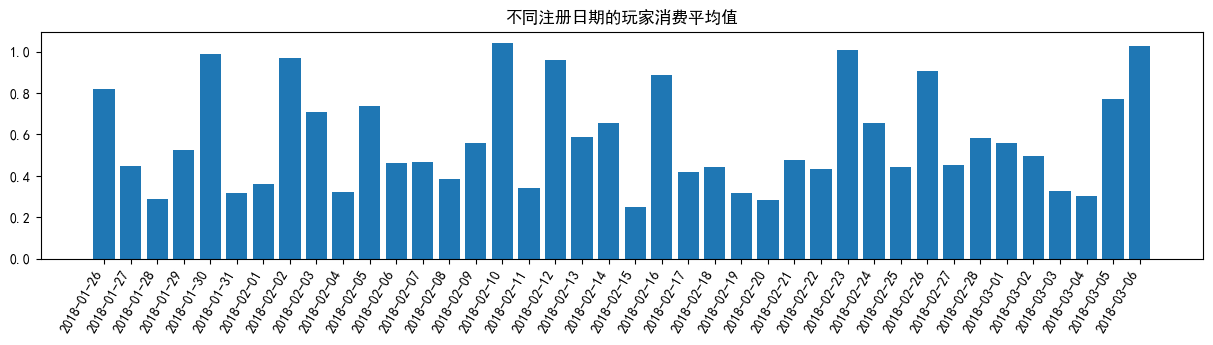

In [81]:
print("按照玩家注册日期对付费金额进行聚合平均计算，再绘制图像看看是否呈现有规律的分布")
RegisterDateMean = data["付费金额"].groupby(RegisterDate).mean()
plt.figure(figsize=(15,3),dpi=100)
plt.title("不同注册日期的玩家消费平均值")
plt.bar(RegisterDateMean.index, RegisterDateMean.values)
plt.xticks(RegisterDateMean.index,rotation=60,ha="right");

- 每隔几天就会有一个高峰跃起，可以将日期转化为一星期中的七天，
- 观察一下星期和消费数额是否有明显的关系。

将注册时间转成星期几，求均值后，再用图像观察！


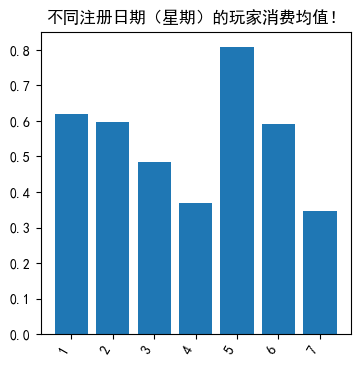

In [82]:
print("将注册时间转成星期几，求均值后，再用图像观察！")
datetime.datetime.strptime(data.loc[0,"玩家注册时间"][:10],"%Y-%m-%d").weekday()
RegisterWeekday = data.loc[:,"玩家注册时间"].apply(lambda x: datetime.datetime.strptime(x[:10],"%Y-%m-%d").weekday()+1) #1~7分别代表周一到周日
RegisterWeekDayMean = data["付费金额"].groupby(RegisterWeekday).mean()
plt.figure(figsize=(4,4),dpi=100)
plt.title("不同注册日期（星期）的玩家消费均值！")
plt.bar(RegisterWeekDayMean.index, RegisterWeekDayMean.values)
plt.xticks(RegisterWeekDayMean.index,rotation=60,ha="right");

- 很明显，周五、周一注册的人有较高的消费金额。
- 这个情况乍一看起来是消费金额与星期相关，但实际上并非如此；游戏注册或者购买、投放的节奏和渠道有关。
- 每周五、每周一都可以排到质量较高的玩家所在的渠道，或者周五会吸引到大量准备过周末的玩家的注意；
- 周一则会吸引到大量还不想投入工作的玩家的注意。
- 周五与周一的高峰暗示这两天进入的流量可能是有规律工作、经济收入的人。可以计算一下星期与45日付费金额的皮尔逊相关系数：

In [83]:
print("可以不必考虑了。。。")
pd.concat([data["45日付费金额"],RegisterWeekday],axis=1).corr()


可以不必考虑了。。。


,45日付费金额,玩家注册时间
45日付费金额,1.000,-0.001
玩家注册时间,-0.001,1.000


将注册的小时时刻也单独列一列，提取小时数作为特征，在画图观察一下


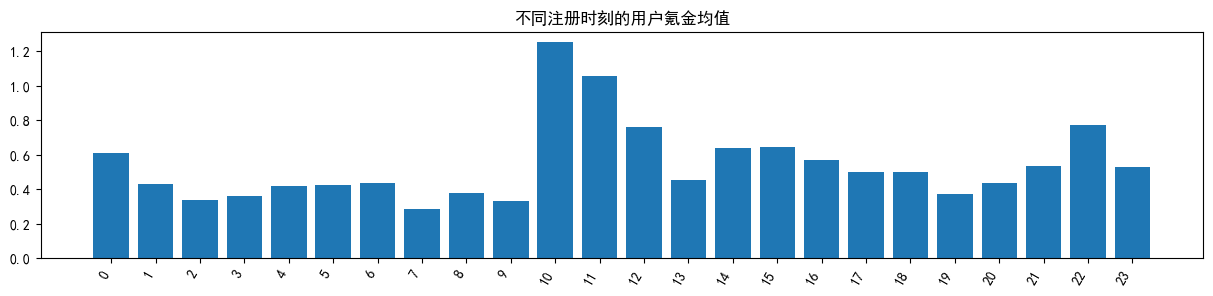

In [84]:
print("将注册的小时时刻也单独列一列，提取小时数作为特征，在画图观察一下")
RegisterTime = data.loc[:,"玩家注册时间"].apply(lambda x: int(x[11:13]))
RegisterTimeMean = data["付费金额"].groupby(RegisterTime).mean()
plt.figure(figsize=(15,3),dpi=100)
plt.title("不同注册时刻的用户氪金均值")
plt.bar(RegisterTimeMean.index, RegisterTimeMean.values)
plt.xticks(RegisterTimeMean.index,rotation=60,ha="right");

早上10点-12点之间注册的用户、以及下午4点-5点之间表现出比其他时段注册的玩家更高的消费能力，这可能是与推广渠道有关，也可能真的是注册时刻与消费金额有关。同时，也来看看相关系数：

In [85]:
print("相关性不高，但是不是0，凑合保留吧，还有点儿用！")
pd.concat([data["45日付费金额"],RegisterTime],axis=1).corr()

相关性不高，但是不是0，凑合保留吧，还有点儿用！


,45日付费金额,玩家注册时间
45日付费金额,1.000,0.001
玩家注册时间,0.001,1.000


In [86]:
data.insert(data.shape[1]-1,"玩家注册时刻",RegisterTime)
data.drop(columns=["玩家注册时间","玩家唯一ID"],inplace=True) #删除不需要的特征
data.head()


字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,玩家注册时刻,45日付费金额
0,20125,3700,0,0,0,0,16375,2000,0,0,...,0,0,0,0,0,0.333,0.000,0,19,0.000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.333,0.000,0,0,0.000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.167,0.000,0,0,0.000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.167,0.000,0,0,0.000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2.333,0.000,0,0,0.000


### P2.数据Benchmark建立流程

In [87]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
y.shape,X.shape

((1048575,), (1048575, 107))

In [88]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size = 0.3,random_state = 0)
Xtrain.shape,Xtest.shape

((734002, 107), (314573, 107))

In [89]:
print("索引恢复！")
for i in [Xtrain, Xtest]:
    i.index = range(i.shape[0])

索引恢复！


In [90]:
reg = LR() #实例化
reg_benchmark = reg.fit(Xtrain,ytrain) #训练

In [91]:
reg_benchmark.score(Xtrain,ytrain) #训练集上的分数 - R2

0.7353042509576684

In [92]:
reg_benchmark.score(Xtest,ytest) #测试集上的分数

0.321699321056062

In [93]:
y_pred = reg_benchmark.predict(Xtest) #测试集上的预测标签

In [94]:
# 根均方误差(RMSE)
np.sqrt(MSE(ytest,y_pred)) #benchmark就是62的RMSE，以及55.8%的r2

62.95938925974633

- 线性回归欠拟合太明显。。。

In [95]:
reg_tree = RFR(n_estimators=10,max_features=5) #100+，max_features=5
reg_tree.fit(Xtrain,ytrain)

RandomForestRegressor(max_features=5, n_estimators=10)

In [96]:
reg_tree.score(Xtrain,ytrain) #训练集上的R2是87%

0.8999230000983364

In [97]:
reg_tree.score(Xtest,ytest) #测试集上的R2是41%

0.356194285941538

In [98]:
np.sqrt(MSE(ytest,reg_tree.predict(Xtest)))


61.33760212202494

- 随机森林，过拟合了已经！

- 不论从R方还是MSE的表现，模型都需要经过特征工程优化！！！！！！

### P3.特征工程环节！

    ### S1.一次特征创造&除零错误处理！

- 基于对游戏的考虑！以下特征可以创造！
> - 个人PVP胜率 = PVP胜利次数/PVP次数，无PVP的用户胜率为0
> - 主动发起PVP的概率 = 主动发起PVP次数/PVP次数，无PVP的用户主动发起为0
> - 玩家发育效率 = 平均资源获取数/在线时长 （该指标高的人擅长游戏）
> - 玩家升级效率 = 技能的平均等级/在线时长
> - 玩家消费后的发育效率 = 平均资源获取数/7日付费金额
> - 玩家消费后的升级效率 = 技能的平均等级/7日付费金额

- 基于前面的一些分析性结果发现，统一让低价值玩家用户被标记为0，高价值用户被标记为1，为特征矩阵创造如下新特征：
- **高价值玩家**
> - 潜力玩家：7日内付费超过6元
> - 好战玩家：主动发起PVP概率大于50%

- **低价值玩家**
> - 佛系玩家：主动发起PVP概率小于20%，或一次也没有参与过PVP
> - 肝帝玩家：7日在线时间过长，或资源量巨大但7日内没有付费
> - 菜鸡玩家：参与过PVP且个人PVP胜率小于10%
> - 流失玩家：7日在线时间过短，或初始资源获取数量小于10000

In [99]:
GrowthFeature = [] #发育 - 关于资源的部分
for i in X.columns:
    if "招募" in i:
        GrowthFeature.append(i)
    elif "获取" in i:
        GrowthFeature.append(i)
LevelUpFeature = [] #等级 - 关于技能的部分
for i in X.columns:
    if "建筑" in i:
        LevelUpFeature.append(i)
    elif "科研" in i:
        LevelUpFeature.append(i)
X["PVP胜率"] = X["PVP胜利次数"]/X["PVP次数"]
X["主动发起PVP的概率"] = X["主动发起PVP次数"]/X["PVP次数"]
X["玩家发育效率"] = X.loc[:,GrowthFeature].mean(axis=1)/X["在线时长"]
X["氪金发育效率"] = X.loc[:,GrowthFeature].mean(axis=1)/X["付费金额"]
X["玩家升级效率"] = X.loc[:,LevelUpFeature].mean(axis=1)/X["在线时长"]
X["氪金升级效率"] = X.loc[:,LevelUpFeature].mean(axis=1)/X["付费金额"]


for newfeature in ["PVP胜率","主动发起PVP的概率","玩家发育效率","玩家升级效率","氪金发育效率","氪金升级效率"]:#避免除零错误
    X.loc[X[newfeature].isnull(),newfeature] = 0 #将所有的空值，变为0
    X.loc[X[newfeature] == float("inf"), newfeature] = 0 #分母很小的这样的情况

In [100]:
#高价值玩家特征标注
X["潜力玩家"] = (X["付费金额"] >= 5.98).astype(int)
X["好战玩家"] = (X["主动发起PVP的概率"] >= 0.5).astype(int)
#低价值玩家特征标注
X["肝帝玩家"] = (X["在线时长"] > 800).apply(lambda x: not x).astype(int)
X["佛系玩家"] = ((X["主动发起PVP的概率"] < 0.2) | (X["PVP次数"] == 0)).apply(lambda x: not x).astype(int)
X["菜鸡玩家"] = ((X["PVP胜率"]< 0.1) & (X["PVP次数"] != 0)).apply(lambda x: not x).astype(int)
X["流失玩家"] = ((X["在线时长"] <= 15) | (X["木头获取数量"] <= 10000)).apply(lambda x: not x).astype(int)

In [101]:
X.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,玩家发育效率,氪金发育效率,玩家升级效率,氪金升级效率,潜力玩家,好战玩家,肝帝玩家,佛系玩家,菜鸡玩家,流失玩家
0,20125,3700,0,0,0,0,16375,2000,0,0,...,8446.162,0.000,2.261,0.000,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0.000,0.000,0.000,0.000,0,0,1,0,1,0


    ### S2.特征层面的相关系数

In [102]:
feature_corr_data = pd.DataFrame() 
for idx, column in enumerate(X.columns):
    corr_ = pd.concat([y,X.loc[:,column]],axis=1).corr().iloc[0,1] #每一列我计算这一列与标签的相关系数
    feature_corr_data.loc[idx,"特征"] = column
    feature_corr_data.loc[idx,"相关系数"] = corr_
print("实际中删除特征的办法慎用，这里暂考虑不删除")
feature_corr_data.sort_values("相关系数",ascending = False).head(10)


实际中删除特征的办法慎用，这里暂考虑不删除


,特征,相关系数
104,付费金额,0.779
4,象牙获取数量,0.688
5,象牙消耗数量,0.678
28,训练加速获取数量,0.670
2,石头获取数量,0.668
22,通用加速获取数量,0.668
0,木头获取数量,0.664
3,石头消耗数量,0.655
1,木头消耗数量,0.650
27,科研加速使用数量,0.635


    ### S3.训练集测试集的比例划分调整

由于之前默认过分两集合都是37开，这个比例也会影响结果

计算完毕！
计算完毕！
计算完毕！
计算完毕！


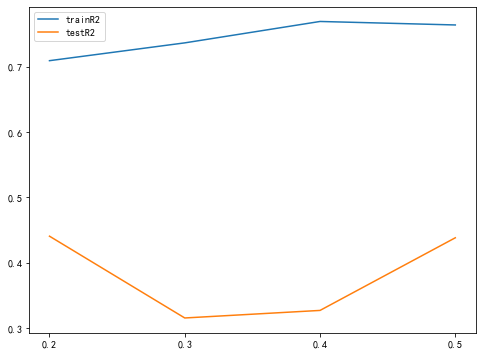

In [103]:
trainR2 = [] #训练集上的R2
testR2 = [] #测试集上的R2
testRMSE = [] #测试集上的RMSE
for i in [0.2,0.3,0.4,0.5]:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=i,random_state=0)
    model = LR().fit(Xtrain,ytrain)
    trainR2.append(model.score(Xtrain,ytrain))
    testR2.append(model.score(Xtest,ytest))
    testRMSE.append(np.sqrt(MSE(ytest,model.predict(Xtest))))
    print("计算完毕！")
plt.figure(figsize=(8,6))
plt.plot(trainR2,label="trainR2")
plt.plot(testR2,label="testR2")
plt.xticks(ticks=[0,1,2,3],labels=[0.2,0.3,0.4,0.5])
plt.legend();

这线性回归太不给力了。。。欠拟合。。。不过可以看到0.4这个比例，分数RMSE均方根最低


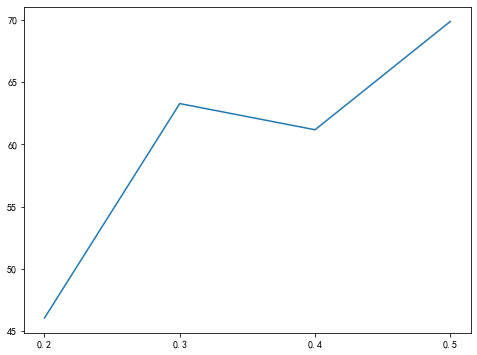

In [104]:
plt.figure(figsize=(8,6))
plt.plot(testRMSE)
plt.xticks(ticks=[0,1,2,3],labels=[0.2,0.3,0.4,0.5]);
print("这线性回归太不给力了。。。欠拟合。。。不过可以看到0.4这个比例，分数RMSE均方根最低")

In [105]:
print("重划分！")
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.4,random_state=0)
ytrain = pd.DataFrame(ytrain)
ytest = pd.DataFrame(ytest)
ytrain.index = Xtrain.index
ytest.index = Xtest.index


重划分！


    ### S4.异常数据处理！——Block

In [106]:
import warnings #消除警告的代码
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
print("训练集和测试集都要分开处理，切记！！")
def AbnormalReplace(Xtrain,Xtest):
    #对7日内没付过费的用户，替换所有异常值为当前特征的中位数或者0
    Xtrain_ = Xtrain.copy()
    Xtest_ = Xtest.copy()
    for column in Xtrain_.columns:
        #提取当前要检测的列
        f_train = Xtrain_.loc[:,column]
        f_test = Xtest_.loc[:,column]
        #从训练集中计算出QL、QU、IQR、中位数
        QL = np.quantile(f_train,0.25)
        QU = np.quantile(f_train,0.75)
        IQR = QU - QL
        medium_train = f_train.median()
        medium_test = f_test.median()
        #对训练集和测试集同时进行检测，得到True/False列表
        errortrain = ((f_train < (QL - 1.5*IQR)).astype(int) + (f_train > (QU + 1.5*IQR)).astype(int)) != 0
        errortest = ((f_test < (QL - 1.5*IQR)).astype(int) + (f_test > (QU + 1.5*IQR)).astype(int)) != 0
        #将原矩阵中的异常值替换为中位数，主题排除7日付费用户
        #如果效果不够强烈，试试看替换为0
        Xtrain_.loc[((Xtrain_["付费金额"]==0).values & errortrain.values),column] = 0 #也可以考虑用代替，换成medium_
        Xtest_.loc[((Xtest_["付费金额"]==0).values & errortest.values),column] = 0
    return Xtrain_, Xtest_

训练集和测试集都要分开处理，切记！！


In [107]:
Xtrain["木头获取数量"].describe()

count       629145.000
mean        454495.435
std        5548033.402
min              0.000
25%              0.000
50%          39371.000
75%         149668.000
max     1203395293.000
Name: 木头获取数量, dtype: float64

In [108]:
xtrain, xtest = AbnormalReplace(Xtrain,Xtest) #为了保留原始的Xtrain和Xtest，新生成的值写作小写
print("分位点明显变化了，偏向趋势弱了一点，正常一点")
xtrain["木头获取数量"].describe() 

分位点明显变化了，偏向趋势弱了一点，正常一点


count       629145.000
mean        255179.116
std        5489714.100
min              0.000
25%              0.000
50%          10000.000
75%          94992.000
max     1203395293.000
Name: 木头获取数量, dtype: float64

    ### S5.异常数据处理！——是否需要量纲统一？——先做个统一的留着！

In [109]:
mm = MinMaxScaler(feature_range = [0,1]) #实例化，[0,1]
mm_train = mm.fit(xtrain) 
xtrain = mm_train.transform(xtrain) #使用训练集上的最小值和最大值对训练集/测试集同时进行归一化
xtest = mm_train.transform(xtest)


# C3.模型考虑是否融合？

### P1.模型融合——为了处理极度偏态的数据影响效应

- 在之前的特征处理中，已经对异常值进行过“盖帽”处理；并在特征中增加认为可以让玩家是否消费区别更明显的特征；
- 但直接让单一模型对玩家是否消费以及消费数额进行预测是非常困难的；
- 故在此可以使用2个模型进行融合预测，第一个模型是分类模型逻辑回归，让逻辑回归先对玩家进行是否消费的预测，
- 然后将逻辑回归认为会消费的玩家放入线性回归，再让线性回归直接对“本来就很可能会消费”的玩家进行金额预测。

    ### S1.逻辑回归预测玩家用户是否会消费！

In [110]:
print('所有在45日消费的玩家转化为1，不消费的转化为0')
y2 = (y != 0).astype(int) #

所有在45日消费的玩家转化为1，不消费的转化为0


In [111]:
y2.value_counts() 

0    1027372
1      21203
Name: 45日付费金额, dtype: int64

In [112]:
print("注意与原来的索引位一一对应！")
ytrain2 = y2[Xtrain.index] #
ytest2 = y2[Xtest.index]

注意与原来的索引位一一对应！


In [113]:
clf_logi = LogiR(random_state = 0)
clf_logi.fit(xtrain,ytrain2) #训练，使用经过标准化特征工程的特征矩阵xtrain

LogisticRegression(random_state=0)

In [114]:
clf_logi.score(xtest,ytest2) #逻辑回归在测试集上预测玩家是否消费的准确率

0.9966168371361133

In [115]:
clf_logi.predict_proba(xtest)#逻辑回归在测试集上每一个样本0-1的概率

array([[0.99812175, 0.00187825],
       [0.99832358, 0.00167642],
       [0.99791012, 0.00208988],
       ...,
       [0.99578817, 0.00421183],
       [0.99729458, 0.00270542],
       [0.99810781, 0.00189219]])

这个ROC有点高啊


0.9612180296251256

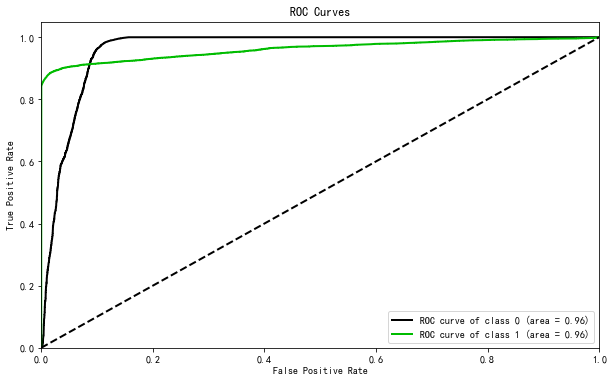

In [116]:
print("这个ROC有点高啊")
skplt.metrics.plot_roc(ytest2,clf_logi.predict_proba(xtest),plot_micro=False,plot_macro=False,figsize=(10,6))
# skplt.metrics.plot_roc_curve(ytest2,clf_logi.predict_proba(xtest),figsize=(10,6),curves=('micro', 'macro', 'each_class'))
roc_auc_score(ytest2,clf_logi.predict_proba(xtest)[:,1])

逻辑回归的结果出乎意料地好，能够在样本不均衡如此严重的情况下达到0.96的ROC，证明逻辑回归对于预测用户是否消费非常适配。

    ### S2.调节阈值提升Recall，找出更多会消费的玩家，不丢掉一个人！

In [117]:
print("默认逻辑回归是按照0.5做01划分")
y2_proba = clf_logi.predict_proba(xtest) 
(y2_proba[:,1] > 0.5).sum()

默认逻辑回归是按照0.5做01划分


6990

In [118]:
print("实际有过消费的玩家！")
(ytest != 0).sum()

实际有过消费的玩家！


45日付费金额    8409
dtype: int64

- 有许多消费的玩家被逻辑回归分类到“不会消费”的类别中，RMSE误差的主要来源就是
- **没有被逻辑回归包括的消费的玩家的消费金额 + 被逻辑回归预测到消费一类、受线性回归预测后的金额差异**。
- 如果希望逻辑回归能够捕捉到所有真实氪金的玩家用户，为此即便误伤一些没有氪金的用户，那就要努力提升Recall，此时RMSE的主要来源就是**被逻辑回归误认为是会消费的玩家的但最终没有消费的玩家在线性回归中的预测值 + 全部真实消费的玩家经过线性回归预测后的金额差异（状况B）**。注意该状况下需要线性回归预测的值会更多。

In [119]:
print("尝试手动修改被判断为1的阈值")
prob = y2_proba[:,1]
(prob > 0.3).astype(int) #阈值为0.3下的预测标签

尝试手动修改被判断为1的阈值


array([0, 0, 0, ..., 0, 0, 0])

In [120]:
print("在0~0.5中循环20个阈值备选数")
for tol in np.linspace(0,0.5,21):
    pred = (prob >= tol).astype(int)
    recall = recall_score(ytest2,pred)
    print("{:.3f} Recall:{:.3f}".format(tol,recall))


在0~0.5中循环20个阈值备选数
0.000 Recall:1.000
0.025 Recall:0.880
0.050 Recall:0.851
0.075 Recall:0.843
0.100 Recall:0.842
0.125 Recall:0.841
0.150 Recall:0.840
0.175 Recall:0.840
0.200 Recall:0.839
0.225 Recall:0.838
0.250 Recall:0.838
0.275 Recall:0.837
0.300 Recall:0.836
0.325 Recall:0.836
0.350 Recall:0.835
0.375 Recall:0.834
0.400 Recall:0.833
0.425 Recall:0.833
0.450 Recall:0.832
0.475 Recall:0.832
0.500 Recall:0.831


In [121]:
for tol in np.linspace(0,0.025,20): #在0~0.026之间再选择一个更小的阈值
    pred = (prob >= tol).astype(int)
    recall = recall_score(ytest2,pred)
    print("{:.3f} Recall:{:.3f}".format(tol,recall))
    

0.000 Recall:1.000
0.001 Recall:0.997
0.003 Recall:0.953
0.004 Recall:0.930
0.005 Recall:0.918
0.007 Recall:0.912
0.008 Recall:0.906
0.009 Recall:0.901
0.011 Recall:0.896
0.012 Recall:0.893
0.013 Recall:0.890
0.014 Recall:0.889
0.016 Recall:0.888
0.017 Recall:0.887
0.018 Recall:0.886
0.020 Recall:0.885
0.021 Recall:0.884
0.022 Recall:0.883
0.024 Recall:0.881
0.025 Recall:0.880


In [122]:
print("可以看到0.016左右,recall变化明显！")
tol_level = 0.016 
(y2_proba[:,1] >= tol_level).sum()

可以看到0.016左右,recall变化明显！


15465

In [123]:
#训练集中的多少样本被预测为1
(clf_logi.predict_proba(xtrain)[:,1] >= tol_level).sum()

23485

In [124]:
print("按照测试集原来的索引位，将原来被预测为1的概率，和按照新阈值0.016标记以后的概率做好标记")
logi_test_result = pd.DataFrame(y2_proba[:,1],index=Xtest.index)
logi_test_result.columns = ["logi_proba"]
logi_test_result["logi_y_pred"] = (logi_test_result["logi_proba"] >= tol_level).astype(int)
logi_test_result.head()

按照测试集原来的索引位，将原来被预测为1的概率，和按照新阈值0.016标记以后的概率做好标记


,logi_proba,logi_y_pred
875680,0.002,0
1046906,0.002,0
646861,0.002,0
704385,0.005,0
798051,0.002,0


In [125]:
print("同样处理训练集！！！")
logi_train_result = pd.DataFrame(clf_logi.predict_proba(xtrain)[:,1],index=Xtrain.index)
logi_train_result.columns = ["logi_proba"]
logi_train_result["logi_y_pred"] = (logi_train_result["logi_proba"] >= tol_level).astype(int)
logi_train_result.head()

同样处理训练集！！！


,logi_proba,logi_y_pred
255696,0.002,0
361162,0.007,0
647896,0.011,0
255552,0.008,0
970897,0.003,0


    ### S3.融合后要被放倒第二个线性回归中的数据集，就是上一步逻辑回归判定会消费的玩家部分，就是logi_y_pred=1的部分

In [126]:
print("融合后的训练集与测试集数据处理！")
xtrain_mix_reg = xtrain[logi_train_result["logi_y_pred"] == 1]
ytrain_mix_reg = ytrain[logi_train_result["logi_y_pred"] == 1]
xtest_mix_reg = xtest[logi_test_result["logi_y_pred"] == 1]
ytest_mix_reg = ytest[logi_test_result["logi_y_pred"] == 1]
xtrain_mix_reg.shape,xtest_mix_reg.shape #确认与训练集中被预测为1的样本数一致


融合后的训练集与测试集数据处理！


((23485, 119), (15465, 119))

    ### S4.开始预测！

In [127]:
def reg_predict(model):
    reg = model.fit(xtrain_mix_reg, ytrain_mix_reg) #训练
    y_linear_pred = reg.predict(xtest_mix_reg) #对测试集进行预测
    print("训练集R2:{:.3f}".format(reg.score(xtrain_mix_reg, ytrain_mix_reg)))
    print("测试集R2:{:.3f}".format(reg.score(xtest_mix_reg, ytest_mix_reg)))
    print("测试集RMSE:{:.3f}".format(np.sqrt(MSE(ytest_mix_reg,y_linear_pred))))
    return y_linear_pred #融合模型预测出的结果中的 - 回归部分
#线性回归
reg0 = LR()
y_linear_pred0 = reg_predict(reg0) 

训练集R2:0.791
测试集R2:0.318
测试集RMSE:317.131


- 严重欠拟合！！！尝试一下树模型和BOOSTING！

In [128]:
reg1 = RFR(n_estimators = 100,max_depth = 2,max_features = 20,random_state = 0)
reg2 = GradientBoostingRegressor(n_estimators = 100,max_depth = 2,max_features = 20,random_state = 0)
y_linear_pred1 = reg_predict(reg1) 

训练集R2:0.676
测试集R2:0.439
测试集RMSE:287.572


In [129]:
y_linear_pred2 = reg_predict(reg2)

训练集R2:0.897
测试集R2:0.444
测试集RMSE:286.398


树模型也无法拯救。。。

In [130]:
reg3 = GradientBoostingRegressor(n_estimators = 490 #首先考虑的是增大模型的树的数量，来提升整体拟合能力
           ,max_depth= 2 #但又很容易过拟合，因此控制住树的深度
           ,learning_rate= 0.05 #当n_estimators和max_depth调不出好结果时，有限考虑降低学习率，学习率对树模型的效果影响很大
           ,max_features = 50 #max_features的存在一开始主要是为了控制建模速度的，但是也可以控制过拟合，可以使用学习曲线找适合的阶段和位置
           ,min_samples_split = 25 #如果模型仍然过拟合，可以试着增加min_samples_split，增大允许分叶子的样本数量，以此来减少树的拟合程度
           ,random_state= 1412)

In [131]:
y_linear_pred2 = reg_predict(reg2)

训练集R2:0.897
测试集R2:0.444
测试集RMSE:286.398


In [132]:
print("原来的数据新增一列，之后将逻辑回归预测为1的部分替换成线性回归预测出的y值")
logi_test_result["reg_result"] = 0 
logi_test_result.loc[logi_test_result["logi_y_pred"] == 1,"reg_result"] = y_linear_pred2

原来的数据新增一列，之后将逻辑回归预测为1的部分替换成线性回归预测出的y值


In [133]:
logi_test_result.head()#与原来测试集ytest索引一致；

,logi_proba,logi_y_pred,reg_result
875680,0.002,0,0.000
1046906,0.002,0,0.000
646861,0.002,0,0.000
704385,0.005,0,0.000
798051,0.002,0,0.000


In [134]:
np.sqrt(MSE(ytest,logi_test_result["reg_result"]))

55.52167021891304

- 这个成绩也足够排进前10了！

### P2.尝试更换复杂一点的模型，这里换成XGBOOST和神经网络！

In [135]:
reg_xgb = XGBRFRegressor()
y_xgb_pred1 = reg_predict(reg_xgb)

训练集R2:0.921
测试集R2:0.491
测试集RMSE:274.038


- S1.通过偏差方差法寻找一下最佳n_estimator！——以往都是score或者均方误差！

R2最高所对应的参数取值：50 R2最高值：0.4369529040770665 R2最高值时的方差：0.031022108406184985
方差最低所对应的参数取值：250 方差最低值时R2：0.42344790085045814 方差最低值：0.0282768955528453
可控误差最低时所对应的参数取值：50 可控误差最低时所对应的R2值：0.4369529040770665 可控误差最低时所对应的方差：0.031022108406184985 可控误差最低时所对应的方差：0.348044140633434


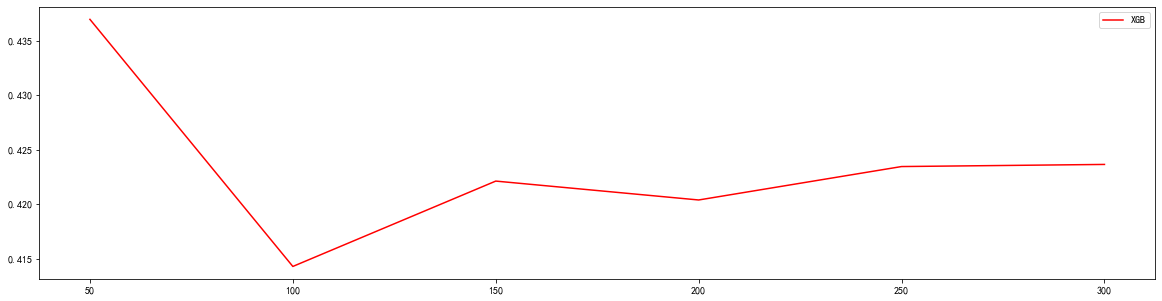

In [136]:
axisx = range(50,350,50)
rs = []
var = []
ge = []
cv_k = KFold(n_splits=5, shuffle = True, random_state=0)
for i in axisx:
    reg_xgb_nes = XGBRFRegressor(n_estimators = i,n_jobs = -1,random_state = 0)
    cvresult = cross_val_score(reg_xgb_nes,xtrain_mix_reg,ytrain_mix_reg,cv = cv_k)#默认还是R方
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())#计算泛化误差的可控部分
#打印R2最高所对应的参数取值，并打印这个参数下的方差
print("R2最高所对应的参数取值：" + str(axisx[rs.index(max(rs))]),"R2最高值：" + str(max(rs)),"R2最高值时的方差：" + str(var[rs.index(max(rs))]))
#打印方差最低时对应的参数取值，并打印这个参数下的R2
print("方差最低所对应的参数取值：" + str(axisx[var.index(min(var))]),"方差最低值时R2：" +str(rs[var.index(min(var))]),"方差最低值：" + str(min(var)))
#打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print("可控误差最低时所对应的参数取值：" + str(axisx[ge.index(min(ge))]),
      "可控误差最低时所对应的R2值：" + str(rs[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(var[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(min(ge)))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()


50 0.4369529040770665 0.031022108406184985
250 0.42344790085045814 0.0282768955528453
50 0.4369529040770665 0.031022108406184985 0.348044140633434


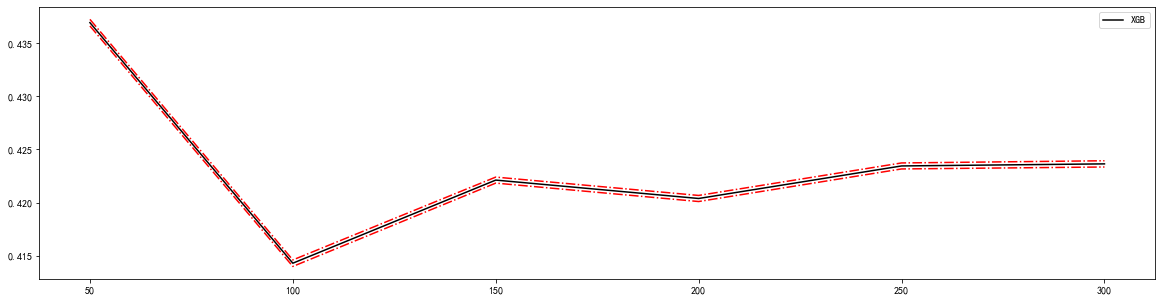

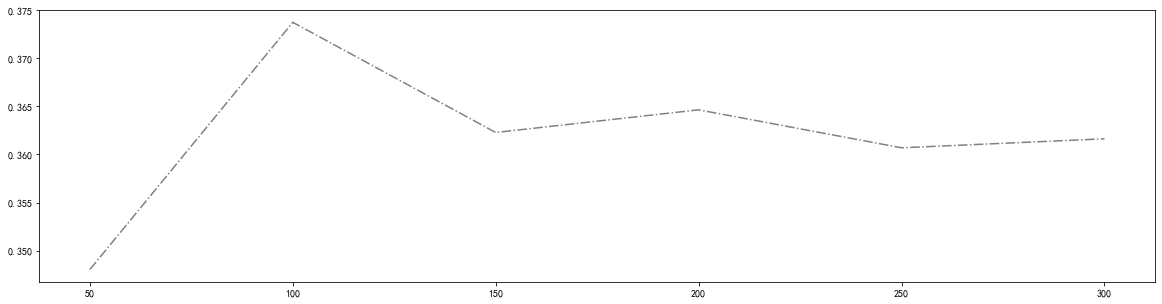

In [137]:
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
#添加方差线
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()
#看看泛化误差的可控部分如何？
plt.figure(figsize=(20,5))
plt.plot(axisx,ge,c="gray",linestyle='-.')
plt.show()


- 可见选50目前来说效果最好

S2.学习率learing_rate和子采样比率subsample！！！

R2最高所对应的参数取值：0.8 R2最高值：0.47273256494254934 R2最高值时的方差：0.01664707077745254
方差最低所对应的参数取值：0.0 方差最低值时R2：-0.010196815233431166 方差最低值：5.1124609882900005e-06
可控误差最低时所对应的参数取值：0.8 可控误差最低时所对应的R2值：0.47273256494254934 可控误差最低时所对应的方差：0.01664707077745254 可控误差最低时所对应的方差：0.2946580188495155


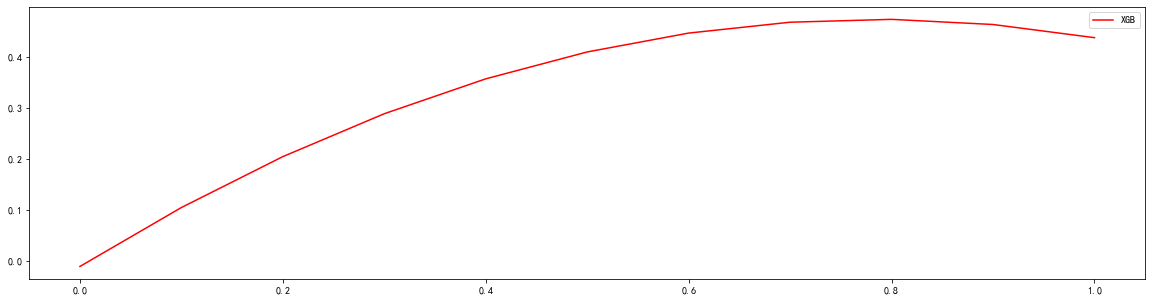

In [138]:
learning_rate = np.linspace(0,1,11)
rs = []
var = []
ge = []
cv_k = KFold(n_splits=5, shuffle = True, random_state=0)
for i in learning_rate:
    reg_xgb_learate = XGBRFRegressor(n_estimators = 50, learning_rate = i ,n_jobs = -1,random_state = 0)
    cvresult = cross_val_score(reg_xgb_learate,xtrain_mix_reg,ytrain_mix_reg,cv = cv_k)#默认还是R方
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())#计算泛化误差的可控部分
print("R2最高所对应的参数取值：" + str(learning_rate[rs.index(max(rs))]),"R2最高值：" + str(max(rs)),"R2最高值时的方差：" + str(var[rs.index(max(rs))]))
print("方差最低所对应的参数取值：" + str(learning_rate[var.index(min(var))]),"方差最低值时R2：" +str(rs[var.index(min(var))]),"方差最低值：" + str(min(var)))
print("可控误差最低时所对应的参数取值：" + str(learning_rate[ge.index(min(ge))]),
      "可控误差最低时所对应的R2值：" + str(rs[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(var[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(min(ge)))
plt.figure(figsize=(20,5))
plt.plot(learning_rate,rs,c="red",label="XGB")
plt.legend()
plt.show()

- 选择0.8！

R2最高所对应的参数取值：0.4 R2最高值：0.5426056752722277 R2最高值时的方差：0.006014469993938197
方差最低所对应的参数取值：0.6 方差最低值时R2：0.5119264136638458 方差最低值：0.004534386828856591
可控误差最低时所对应的参数取值：0.4 可控误差最低时所对应的R2值：0.5426056752722277 可控误差最低时所对应的方差：0.006014469993938197 可控误差最低时所对应的方差：0.21522403828711303


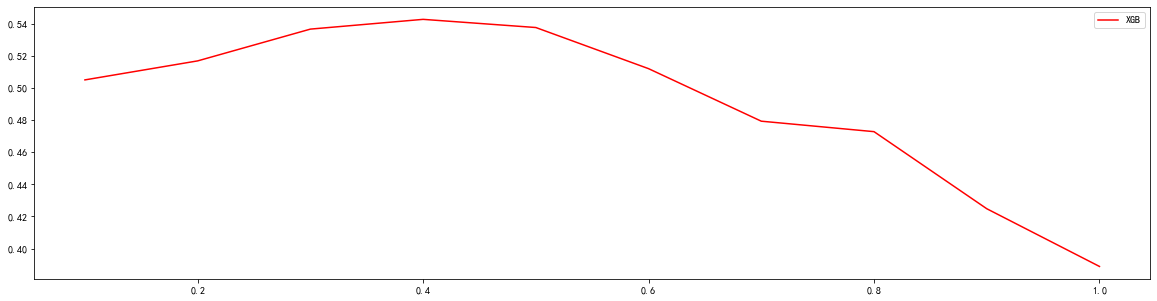

In [139]:
subsample_rate = np.linspace(0.1,1,10)
rs = []
var = []
ge = []
cv_k = KFold(n_splits=5, shuffle = True, random_state=0)
for i in subsample_rate:
    reg_xgb_subs = XGBRFRegressor(n_estimators = 50, learning_rate = 0.8, subsample = i,n_jobs = -1,random_state = 0)
    cvresult = cross_val_score(reg_xgb_subs,xtrain_mix_reg,ytrain_mix_reg,cv = cv_k)#默认还是R方
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())#计算泛化误差的可控部分
print("R2最高所对应的参数取值：" + str(subsample_rate[rs.index(max(rs))]),"R2最高值：" + str(max(rs)),"R2最高值时的方差：" + str(var[rs.index(max(rs))]))
print("方差最低所对应的参数取值：" + str(subsample_rate[var.index(min(var))]),"方差最低值时R2：" +str(rs[var.index(min(var))]),"方差最低值：" + str(min(var)))
print("可控误差最低时所对应的参数取值：" + str(subsample_rate[ge.index(min(ge))]),
      "可控误差最低时所对应的R2值：" + str(rs[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(var[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(min(ge)))
plt.figure(figsize=(20,5))
plt.plot(subsample_rate,rs,c="red",label="XGB")
plt.legend()
plt.show()

- 选择0.4！——目前
reg_xgb_subs = XGBRFRegressor(n_estimators = 50, learning_rate = 0.8, subsample = 0.4,n_jobs = -1,random_state = 0)

S3.弱评估器的框架参数——影响树生长——为保证速度效率，采用网格搜索，但参数又不能太多！选几个重要的很影响树生长的！
- max_depth/gamma/min_child_weight/

R2最高所对应的参数取值：5 R2最高值：0.5439863668922115 R2最高值时的方差：0.006085973393405728
方差最低所对应的参数取值：18 方差最低值时R2：0.5429224399015606 方差最低值：0.005660046518601523
可控误差最低时所对应的参数取值：5 可控误差最低时所对应的R2值：0.5439863668922115 可控误差最低时所对应的方差：0.006085973393405728 可控误差最低时所对应的方差：0.21403440697357048


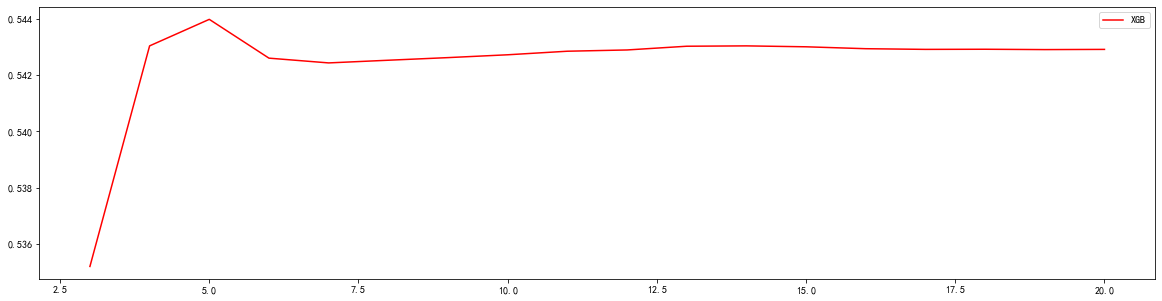

In [140]:
max_depth_para = range(3,21)
rs = []
var = []
ge = []
cv_k = KFold(n_splits=5, shuffle = True, random_state=0)
for i in max_depth_para:
    reg_xgb_depth = XGBRFRegressor(n_estimators = 50, learning_rate = 0.8, subsample = 0.4, max_depth = i, n_jobs = -1,random_state = 0)
    cvresult = cross_val_score(reg_xgb_depth,xtrain_mix_reg,ytrain_mix_reg,cv = cv_k)#默认还是R方
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())#计算泛化误差的可控部分
print("R2最高所对应的参数取值：" + str(max_depth_para[rs.index(max(rs))]),"R2最高值：" + str(max(rs)),"R2最高值时的方差：" + str(var[rs.index(max(rs))]))
print("方差最低所对应的参数取值：" + str(max_depth_para[var.index(min(var))]),"方差最低值时R2：" +str(rs[var.index(min(var))]),"方差最低值：" + str(min(var)))
print("可控误差最低时所对应的参数取值：" + str(max_depth_para[ge.index(min(ge))]),
      "可控误差最低时所对应的R2值：" + str(rs[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(var[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(min(ge)))
plt.figure(figsize=(20,5))
plt.plot(max_depth_para,rs,c="red",label="XGB")
plt.legend()
plt.show()


- 定5-10暂时！

R2最高所对应的参数取值：0.0 R2最高值：0.5426056752722277 R2最高值时的方差：0.006014469993938197
方差最低所对应的参数取值：0.0 方差最低值时R2：0.5426056752722277 方差最低值：0.006014469993938197
可控误差最低时所对应的参数取值：0.0 可控误差最低时所对应的R2值：0.5426056752722277 可控误差最低时所对应的方差：0.006014469993938197 可控误差最低时所对应的方差：0.21522403828711303


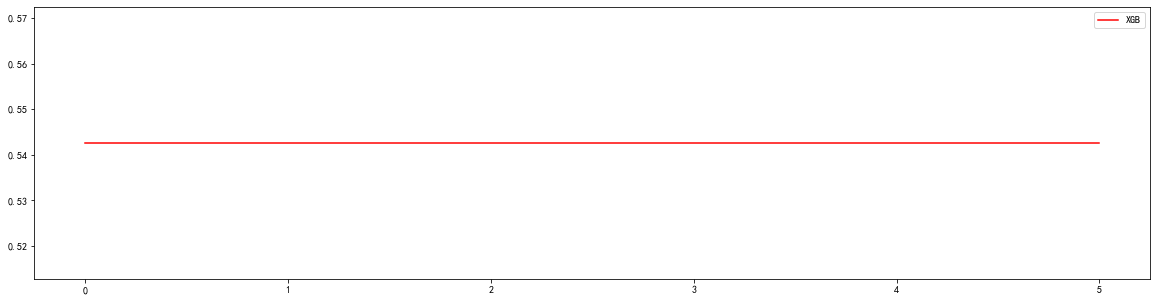

In [141]:
gamma_para = np.linspace(0,5,51)
rs = []
var = []
ge = []
cv_k = KFold(n_splits=5, shuffle = True, random_state=0)
for i in gamma_para:
    reg_xgb_gamma = XGBRFRegressor(n_estimators = 50, learning_rate = 0.8, subsample = 0.4, gamma = i, n_jobs = -1,random_state = 0)
    cvresult = cross_val_score(reg_xgb_gamma,xtrain_mix_reg,ytrain_mix_reg,cv = cv_k)#默认还是R方
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())#计算泛化误差的可控部分
print("R2最高所对应的参数取值：" + str(gamma_para[rs.index(max(rs))]),"R2最高值：" + str(max(rs)),"R2最高值时的方差：" + str(var[rs.index(max(rs))]))
print("方差最低所对应的参数取值：" + str(gamma_para[var.index(min(var))]),"方差最低值时R2：" +str(rs[var.index(min(var))]),"方差最低值：" + str(min(var)))
print("可控误差最低时所对应的参数取值：" + str(gamma_para[ge.index(min(ge))]),
      "可控误差最低时所对应的R2值：" + str(rs[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(var[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(min(ge)))
plt.figure(figsize=(20,5))
plt.plot(gamma_para,rs,c="red",label="XGB")
plt.legend()
plt.show()


- 可以默认。。。

R2最高所对应的参数取值：0 R2最高值：0.5426056752722277 R2最高值时的方差：0.006014469993938197
方差最低所对应的参数取值：0 方差最低值时R2：0.5426056752722277 方差最低值：0.006014469993938197
可控误差最低时所对应的参数取值：0 可控误差最低时所对应的R2值：0.5426056752722277 可控误差最低时所对应的方差：0.006014469993938197 可控误差最低时所对应的方差：0.21522403828711303


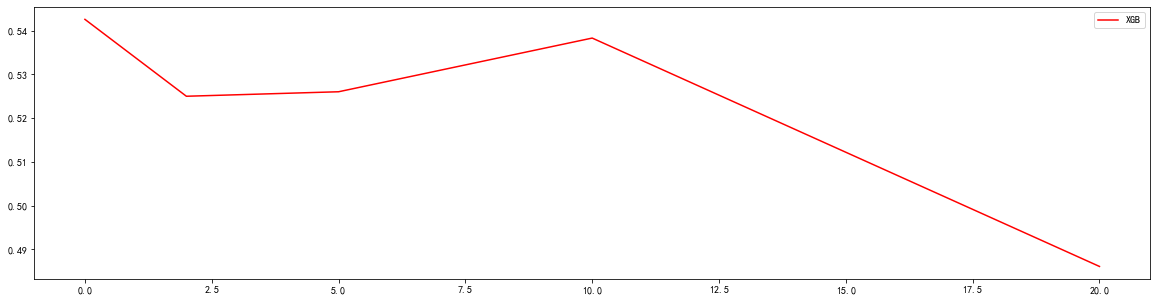

In [142]:
min_child_weight_para = [0, 2, 5, 10, 20]
rs = []
var = []
ge = []
cv_k = KFold(n_splits=5, shuffle = True, random_state=0)
for i in min_child_weight_para:
    reg_xgb_min_child_weight = XGBRFRegressor(n_estimators = 50, learning_rate = 0.8, subsample = 0.4, min_child_weight = i, n_jobs = -1,random_state = 0)
    cvresult = cross_val_score(reg_xgb_min_child_weight, xtrain_mix_reg, ytrain_mix_reg, cv = cv_k)#默认还是R方
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())#计算泛化误差的可控部分
print("R2最高所对应的参数取值：" + str(min_child_weight_para[rs.index(max(rs))]),
      "R2最高值：" + str(max(rs)),
      "R2最高值时的方差：" + str(var[rs.index(max(rs))]))
print("方差最低所对应的参数取值：" + str(min_child_weight_para[var.index(min(var))]),
      "方差最低值时R2：" +str(rs[var.index(min(var))]),
      "方差最低值：" + str(min(var)))
print("可控误差最低时所对应的参数取值：" + str(min_child_weight_para[ge.index(min(ge))]),
      "可控误差最低时所对应的R2值：" + str(rs[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(var[ge.index(min(ge))]),
      "可控误差最低时所对应的方差：" + str(min(ge)))
plt.figure(figsize=(20,5))
plt.plot(min_child_weight_para,rs,c="red",label="XGB")
plt.legend()
plt.show()


In [143]:
reg_xgb_para = XGBRFRegressor(learning_rate = 0.8, subsample = 0.4,n_jobs = -1,random_state = 0)
param_test = {'max_depth':[5,6,7,8,9,10], 
#                'gamma':np.linspace(0.4,0.8,5),
               'min_child_weight':[0, 1, 10],
               'n_estimators':[50,100,150,200,250]}
grid_searchcv =  GridSearchCV(estimator = reg_xgb_para ,param_grid = param_test ,n_jobs = -1 ,scoring='r2',cv=3)
grid_searchcv.fit(xtrain_mix_reg, ytrain_mix_reg)

GridSearchCV(cv=3,
             estimator=XGBRFRegressor(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bytree=None, gamma=None,
                                      gpu_id=None, importance_type='gain',
                                      interaction_constraints=None,
                                      learning_rate=0.8, max_delta_step=None,
                                      max_depth=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=-1,
                                      num_parallel_tree=None,
                                      objective='reg:squarederror',
                                      random_state=0, reg_alpha=None,
                                      scale_pos_weight=None, subsample=0.4,
                                      tree_method=None,
  

In [144]:
grid_searchcv.best_estimator_,grid_searchcv.best_params_,grid_searchcv.best_score_

(XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.8, max_delta_step=0,
                max_depth=10, min_child_weight=0, missing=nan,
                monotone_constraints='()', n_estimators=50, n_jobs=-1,
                num_parallel_tree=50, objective='reg:squarederror',
                random_state=0, reg_alpha=0, scale_pos_weight=1, subsample=0.4,
                tree_method='exact', validate_parameters=1, verbosity=None),
 {'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 50},
 0.5339752684600007)

- 最终的网格给的xg；
- reg_xgb_para = XGBRFRegressor(n_estimators = 50, learning_rate = 0.8, subsample = 0.4, max_depth = 10, min_child_weight = 0, n_jobs = -1, random_state = 0)

In [145]:
reg_xgb_formal = XGBRFRegressor(n_estimators = 300, learning_rate = 0.8, subsample = 0.4, max_depth = 10, min_child_weight = 0, n_jobs = -1, random_state = 0)
reg_xgb_formal

XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bytree=None, gamma=None, gpu_id=None,
               importance_type='gain', interaction_constraints=None,
               learning_rate=0.8, max_delta_step=None, max_depth=10,
               min_child_weight=0, missing=nan, monotone_constraints=None,
               n_estimators=300, n_jobs=-1, num_parallel_tree=None,
               objective='reg:squarederror', random_state=0, reg_alpha=None,
               scale_pos_weight=None, subsample=0.4, tree_method=None,
               validate_parameters=None, verbosity=None)

In [146]:
y_xgb_pred = reg_predict(reg_xgb_formal) 

训练集R2:0.763
测试集R2:0.489
测试集RMSE:274.431


In [147]:
print("原来的数据新增一列，之后将逻辑回归预测为1的部分替换成线性回归预测出的y值")
logi_test_result["reg_result_xgb"] = 0 
logi_test_result.loc[logi_test_result["logi_y_pred"] == 1,"reg_result_xgb"] = y_xgb_pred
logi_test_result.head(200)#与原来测试集ytest索引一致；

原来的数据新增一列，之后将逻辑回归预测为1的部分替换成线性回归预测出的y值


,logi_proba,logi_y_pred,reg_result,reg_result_xgb
875680,0.002,0,0.000,0.000
1046906,0.002,0,0.000,0.000
646861,0.002,0,0.000,0.000
704385,0.005,0,0.000,0.000
798051,0.002,0,0.000,0.000
...,...,...,...,...
795096,0.001,0,0.000,0.000
990875,0.002,0,0.000,0.000
696668,1.000,1,27.004,13.262
1002649,0.002,0,0.000,0.000


In [148]:
logi_test_result.head()#与原来测试集ytest索引一致；

,logi_proba,logi_y_pred,reg_result,reg_result_xgb
875680,0.002,0,0.000,0.000
1046906,0.002,0,0.000,0.000
646861,0.002,0,0.000,0.000
704385,0.005,0,0.000,0.000
798051,0.002,0,0.000,0.000


In [149]:
np.sqrt(MSE(ytest,logi_test_result["reg_result_xgb"]))

53.24656965404968

- XGB降到53.24了！！
——第五名！
https://js.dclab.run/v2/cmptDetail.html?id=226

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/micro_class/sklearncase/%E6%8E%92%E8%A1%8C%E6%A6%9C.PNG)

### P3.尝试神经网络！

In [150]:
import tensorflow as tf
xtrain_mix_reg.shape,ytrain_mix_reg.shape

((23485, 119), (23485, 1))

- 定义网络架构！
>  119个特征，先从128开始，隐藏层为防止过拟合，先定义5层；

In [212]:
model_DNN = tf.keras.Sequential([
tf.keras.layers.Dense(128, activation = 'relu', input_shape=(xtrain_mix_reg.shape[1],)),#119个特征，先从128个开始
tf.keras.layers.Dense(96, activation = 'relu'),
tf.keras.layers.Dense(64, activation = 'relu'),
tf.keras.layers.Dense(32, activation = 'relu'),
tf.keras.layers.Dense(16,  activation = 'relu'),
tf.keras.layers.Dense(8,  activation = 'relu'),
tf.keras.layers.Dense(4,  activation = 'relu'),
tf.keras.layers.Dense(1)
])
model_DNN.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 128)               15360     
_________________________________________________________________
dense_137 (Dense)            (None, 96)                12384     
_________________________________________________________________
dense_138 (Dense)            (None, 64)                6208      
_________________________________________________________________
dense_139 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_140 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_141 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_142 (Dense)            (None, 4)               

- 定义损失函数！损失函数选用Adam;

训练数据,优化器选择Adam，学习率0.01


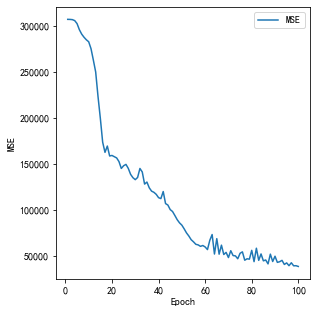

In [213]:
# model_DNN.compile(optimizer = 'Adam',loss = 'mse', metrics=['mae','mse'], verbose = 0)
# model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1),loss = tf.keras.losses.CategoricalCrossentropy(),metrics = ['accuracy'])
model_DNN.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
             loss = 'mse',
             metrics = ['mae','mse'])
print("""训练数据,优化器选择Adam，学习率0.01""")
train_history = model_DNN.fit(xtrain_mix_reg, ytrain_mix_reg, batch_size = 200, epochs=100, verbose = 0) #训练日志太多了不输出了。每一次训练放128个，
history_frame = pd.DataFrame(train_history.history)
history_frame['epoch'] = train_history.epoch
history_frame['epoch'] = history_frame['epoch'] + 1
# """修改列名"""
# hist.rename(columns={'mean_absolute_error':'MAE', 'mean_squared_error':'MSE'},inplace = True)
# print(hist)
def plot_history(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(hist['epoch'], hist['mse'],label='MSE')
    plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.xlabel('Epoch')
#     plt.ylabel('MAE')
#     plt.plot(history_frame['epoch'], history_frame['mae'],label = 'MAE',color ='red')
#     plt.ylim([3,4.5])
#     plt.legend()
plot_history(history_frame)


In [214]:
print("原来的数据新增一列，之后将逻辑回归预测为1的部分替换成线性回归预测出的y值")
logi_test_result["reg_result_dnn"] = 0 
logi_test_result.loc[logi_test_result["logi_y_pred"] == 1,"reg_result_dnn"] = model_DNN.predict(xtest_mix_reg)
logi_test_result.head(200)#与原来测试集ytest索引一致；
np.sqrt(MSE(ytest,logi_test_result["reg_result_dnn"]))


原来的数据新增一列，之后将逻辑回归预测为1的部分替换成线性回归预测出的y值


58.38548194592863

- 拓展到原数据集上！——看一下最终结果！

- DNN网络RMSE-58.38;排在第25/566名；
- 排名成绩没有XGBOOST——53.24好。。。毕竟XGBOOST感情深一口闷吧；
